<a href="https://colab.research.google.com/github/Louisfhgr/Dash.py/blob/master/Vorw%C3%A4rtsbewegung_standartisieren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install loguru

In [26]:
import math
from abc import ABC, abstractmethod
from datetime import datetime

import geopy.distance
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from loguru import logger
from pyproj import Transformer
from scipy.signal import savgol_filter


class PhysicsComputer(ABC):
    """ Contains methods that are common for both SkiAlpine and SkiCrossCountry Class. It's the abstract base class
    that not will be initiated but that will be the blueprint for SkiAlpine and SkiCrossCountry classes."""

    DEFAULT_CONFIG = {
        'savitzky_golay': {
            'window_size':
                {'none': 11, 'DH': 11, 'SX': 11,'GS': 11, 'SL': 7, 'XC': 151},
            'order':
                {'none': 3, 'DH': 3, 'SX': 3, 'GS': 3, 'SL': 3, 'XC': 3}
        }
    }


    def __init__(self, df: pd.DataFrame, config:dict):
        """
        :param df: pandas DataFrame with raw data
        :param config: config dictionary that sets values for different filters aso.
        """
        self._original = df
        self._df = df
        self.config = config

    @abstractmethod
    def compute(self):
        """ Define method that executes all calculations for either SkiAlpine- or SkiCrossCountry-Instance"""
        pass

    def plot(self, feature: str|list[str] = None, title: str = None) -> go.Figure:
        """ Offers a simple plot-API to visualize a singe feature ort multiple features in time

        :param title: optional plot-title as string
        :param feature: feature to be visualized as string or list of features
        """
        features = []
        if feature is None:
            raise f"Please select a feature from DataFrame!"
        elif isinstance(feature, str) and feature not in self._df.columns:
            raise Exception(f"Feature {feature} not found")
        elif isinstance(feature, str) and feature in self._df.columns:
            features.append(feature)
        elif isinstance(feature, list):
            features = [i for i in feature if i in self._df.columns]
            if len(features) == 0:
                raise Exception(f"Feature {feature} not found")
            elif len(features) != len(feature):
                logger.info(f"Dropped {len(feature)- len(features)} feature(s)")

        if len(features) != 0:
            x = self._df['time'] if 'time' in self._df.columns else self._df.index
            title = dict(text=title if title is not None else f"feature: {','.join(features)}", font=dict(size=28))
            if len(features) > 1:
                fig = go.Figure()
                for i in range(len(features)):
                    fig.add_trace(go.Scatter(x=x, y=self._df[features[i]],
                                             mode='lines',
                                             name=features[i]))
            else:
                fig = px.line(self._df, x=x, y=features[0], title=f'{",".join(features)}'.upper())
            fig.update_layout(template='plotly_white', title=title)
            return fig

    def export_csv(self, path: str) -> None:
        """ Exports calculated data to a .csv-File.

        :param path: output-path as string
        """
        EXPORTED_COLUMNS = ['elevation', 'latitude', 'longitude','tf_id', 'discipline_from_name', 'time', 'date',
                            'x_norm', 'y_norm', 'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
                            'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp', 'v_elevation_sp',
                            'a_elevation_sp', 'k', 'k_xy', 'distance', 'distance_x_y', 'v']
        df = self._df[EXPORTED_COLUMNS].copy()
        df.to_csv(path, index=False)

    @staticmethod
    def _transform_to_x_y(coord1: tuple, coord2: tuple) -> (float, float):
        """ Actually transforms the coordinates x and y
        source: https://chatgpt.com/c/71f7ea04-2b95-4b07-96ee-fc5ccbf41532

        :param coord1: tuple containing latitude and longitude of starting point; exp: (46.5, 8.3)
        :param coord2: tuple containing latitude and longitude of ending point; exp: (46.5, 8.3)
        :return: tuple containing 2 floats with distance in meters between the 2 given coordinates in x and y direction
        """
        utm_zone = math.ceil((coord1[1] + 180) / 6)
        hemisphere = 'N' if coord1[0] >= 0 else 'S'
        wgs84 = 'epsg:4326'
        utm = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +{'south' if hemisphere == 'S' else 'north'}"
        transformer = Transformer.from_crs(wgs84, utm)
        x1, y1 = transformer.transform(coord1[0], coord1[1])
        x2, y2 = transformer.transform(coord2[0], coord2[1])
        relative_x = x2 - x1
        relative_y = y2 - y1
        return relative_x, relative_y

    @staticmethod
    def _apply_savitzky_golay(dff: pd.DataFrame, filter_for: tuple, window_size: int, order: int) -> pd.DataFrame:
        """ Applies smoothing with Savitzky-Golay to given columns in pandas DataFrame with certain window_size and order

        :param dff: pandas DataFrame with raw data
        :param filter_for: tuple with column-names in DataFrame as string that should be modified
        :param window_size: length of Savitzky-Golay window as integer
        :param order: order of Savitzky-Golay Filter
        :return: modified pandas DataFrame
        """
        # https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
        # https://gist.github.com/krvajal/1ca6adc7c8ed50f5315fee687d57c3eb
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

        for item in filter_for:
            if item not in dff.columns:
                continue

            val = dff[item].values
            dff[f"{item}_sp"] = savgol_filter(val, window_size, order)
            dff[f"v_{item}_sp"] = savgol_filter(val, window_size, order, deriv=1)
            dff[f"a_{item}_sp"] = savgol_filter(val, window_size, order, deriv=2)

        return dff

    def _modify_config(self, config: dict=None) -> dict:
        """ Modifies config file with the goal that all needed values are existing. If they do not exist in given config
        discipline specific default values from parent class will be taken, else given values will be taken.

        :param config: optional config dictionary that contains values for different filters and settings.
        :return: modified_config (merged with discipline specific DEFAULT_CONFIG from PhysicsComputer) with all needed values
        """
        def _merge_dicts(config, modified_config):
            for key, value in config.items():
                if isinstance(value, dict) and key in modified_config:
                    _merge_dicts(value, modified_config[key])
                else:
                    if key in modified_config:
                        modified_config[key] = value
            return modified_config

        if 'discipline_from_name' not in self._df.columns:
            raise Exception("discipline_from_name not defined in initial DataFrame!")

        discipline = self._df['discipline_from_name'].iloc[0]

        ws = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('window_size').get(discipline)
        order = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('order').get(discipline)
        modified_config = {}
        modified_config.update({'savitzky_golay': {'window_size': ws, 'order': order}})

        if config is not None:
            modified_config = _merge_dicts(config, modified_config)

        if not 'savitzky_golay' in modified_config or not 'window_size' in modified_config[
            'savitzky_golay'] or not 'order' in modified_config['savitzky_golay']:
            raise Exception(f"Something went wrong with initialisation of config! config: {config}")

        return modified_config

    def _convert_timestamp(self) -> None:
        """ Modifies timestamp from format "%Y%m%dT%H%M%S%f" to separate columns date "%Y-%m-%d" and time "%H:%M:%S."
        as string.
        """
        self._df['datetime'] = pd.to_datetime(self._df['timestamp'], format='%Y%m%dT%H%M%S%f')
        self._df["time"] = self._df["datetime"].dt.strftime("%H:%M:%S.") + (
                    self._df['datetime'].dt.microsecond // 100000).astype(str)
        self._df["date"] = self._df["datetime"].dt.strftime("%Y-%m-%d")
        self._df = self._df.drop(columns=["datetime"])

    def _compute_x_y_z(self) -> None:
        """ Transforms the original coordinates in x and y coordinates in meters and x_rel, y_rel and z_rel as difference
        between 2 measuring points. The starting point for x and y will always be at (0,0)
        """

        self._df = self._df.reset_index(drop=True)
        # transform columns to numeric columns -> all non-numeric values will be set to nan
        self._df['latitude'] = pd.to_numeric(self._df['latitude'], errors="coerce")
        self._df['longitude'] = pd.to_numeric(self._df['longitude'], errors="coerce")
        self._df.dropna(subset=['longitude', 'latitude'], inplace=True)
        # calculates distance im meters from actoil location to starting point
        self._df['x_y_from_origin'] = self._df.apply(
            lambda x: self._transform_to_x_y((self._df.loc[0, 'latitude'], self._df.loc[0, 'longitude']),
                                       (x['latitude'], x['longitude'])), axis=1)
        self._df[['x_norm', 'y_norm']] = pd.DataFrame(self._df['x_y_from_origin'].tolist(), index=self._df.index)
        self._df['x_rel'] = self._df['x_norm'].diff()
        self._df['y_rel'] = self._df['y_norm'].diff()
        if 'z' in self._df.columns:
            self._df['z_rel'] = self._df['z'].diff()
        self._df.drop('x_y_from_origin', axis=1, inplace=True)

    def _compute_savitzky_golay_and_derivatives(self) -> None:
        """ Calls savitzky-golay-filter for defined features
        """
        filter_for =  ('x_norm', 'y_norm', 'elevation')
        self._df = self._apply_savitzky_golay(dff=self._df,
                                        filter_for=filter_for,
                                        window_size=self.config['savitzky_golay']['window_size'],
                                        order=self.config['savitzky_golay']['order'])

    def _compute_k(self) -> None:
        """ Computes 'curvature'
        """
        def _calc_k_3D(row: pd.Series) -> float:
            v = [row['v_x_norm_sp'], row['v_y_norm_sp'], row['v_elevation_sp']]
            a = [row['a_x_norm_sp'], row['a_y_norm_sp'], row['a_elevation_sp']]
            cp = np.cross(v, a)
            l = math.sqrt(cp[0] ** 2 + cp[1] ** 2 + cp[2] ** 2)
            v_sp = math.sqrt(row['v_x_norm_sp'] ** 2 + row['v_y_norm_sp'] ** 2 + row['v_elevation_sp'] ** 2)
            return l / v_sp ** 3

        self._df['k'] = self._df.apply(lambda row: pd.Series(_calc_k_3D(row)), axis=1)

    def _compute_k_xy(self) -> None:
        """ Calculates 'curvature' in 2-dimensional-space (x-y-plane)
        """

        def _calc_k_2D(row: pd.Series) -> float:
            vx, vy = row['v_x_norm_sp'], row['v_y_norm_sp']  # 2D-Geschwindigkeitskomponenten
            ax, ay = row['a_x_norm_sp'], row['a_y_norm_sp']  # 2D-Beschleunigungskomponenten
            cp = vx * ay - vy * ax  # 2D-"Kreuzprodukt" (nur Betrag für xy-Ebene)
            v_sp = math.sqrt(vx ** 2 + vy ** 2) # Betrag der Geschwindigkeit in 2D
            return abs(cp) / v_sp ** 3

        self._df['k_xy'] = self._df.apply(lambda row: pd.Series(_calc_k_2D(row)), axis=1)

    def _compute_distances(self) -> None:
        """ Computes distances between 2 coordinate-points
        """
        # add shifts to x_norm, y_norm, latitude and longitude
        self._df['shifted_x_norm'] = self._df['x_norm'].shift(periods=1)
        self._df['shifted_y_norm'] = self._df['y_norm'].shift(periods=1)
        self._df['shifted_latitude'] = self._df['latitude'].shift(periods=1)
        self._df['shifted_longitude'] = self._df['longitude'].shift(periods=1)

        def _calculate_distance(row: pd.Series) -> float:
            """ Calculation of distance in meters between 2 coordinate points based on original longitude and latitude

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance between last 2 coordinate points in meters
            """

            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            return geopy.distance.geodesic((row['latitude'], row['longitude']),
                                           (row['shifted_latitude'], row['shifted_longitude'])).m

        def _calculate_distance_from_x_y(row: pd.Series) -> float:
            """ Calculation of distance in meters based on transformed x and y (metric) coordinates. This calculation is used
            to validate either coordinate transformation and calculation of distance

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance in [m] between 2 coordinates
            """
            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            distance = math.sqrt(
                (row['x_norm'] - row['shifted_x_norm']) ** 2 + (row['y_norm'] - row['shifted_y_norm']) ** 2)
            return distance

        self._df['distance'] = self._df.apply(_calculate_distance, axis=1)
        self._df['distance_x_y'] = self._df.apply(_calculate_distance_from_x_y, axis=1)

    def _compute_v(self) -> None:
        """ Calculates speed
        """
        def _calculate_time_delta(df: pd.DataFrame) -> pd.DataFrame:
            """ Transforms single columns 'date' and 'time' to a date_time column in the datetime-format with tenth of a second
            ('%Y-%m-%d %H:%M:%S.%f') and adds feature 'time_delta' that is 'date_time' shifted by one period.

            :param df: pandas DataFrame with raw data
            :return: modified pandas DataFrame with added/modified date_time content
            """
            df["date_time"] = df["date"] + " " + df["time"]

            try:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
            except ValueError:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

            df['shifted_date_time'] = df['date_time'].shift(periods=1)
            df.loc[0, 'shifted_date_time'] = df.loc[0, 'date_time']
            df['time_delta'] = df['date_time'] - df['shifted_date_time']
            df['time_delta'] = df['time_delta'].apply(lambda x: x.total_seconds())
            return df

        def _calculate_speed(row: pd.Series) -> float:
            """ Calculates the speed in [m/s] based on distance between 2 calculated x and y coordinates and the according
            time-gap between this 2 coordinates

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a speed calculation in [m/s] as float
            """
            if row['time_delta'] == 0:
                return 0
            speed = row['distance_x_y'] / row['time_delta']
            return speed

        self._df = _calculate_time_delta(self._df)
        self._df["v"] = self._df.apply(lambda row: pd.Series(_calculate_speed(row)), axis=1)

In [27]:
import pandas as pd
from loguru import logger



class SkiCrossCountry(PhysicsComputer):
    def __init__(self, df: pd.DataFrame, config:dict=None):
        """
        :param df: pandas DataFrame with raw values
        :param config: optional config dictionary that sets values for different filters aso.
        """
        self._df = df
        config = self._modify_config(config)
        super().__init__(df, config)

    @staticmethod
    def _compute_xc_specific_physical_size() -> None:
        """ Computes cross-country-specific physical sizes (at the moment none).
        """
        logger.info("xc specific")

    def compute(self):
        self._convert_timestamp()
        self._compute_x_y_z()
        self._compute_savitzky_golay_and_derivatives()
        self._compute_k()
        self._compute_k_xy()
        self._compute_distances()
        self._compute_v()
        self._compute_xc_specific_physical_size()
        return self._df


-------------------------------------------------------------------------

## Daten hochladen

In [28]:
import os
print(os.listdir())

['.config', 'Goms_2024-01-27_nadine_faehndrich_run_2.csv', 'export_data_transformed.csv', 'Goms_2024-01-27_nadine_faehndrich_run_1.csv', 'sample_data']


In [29]:
#from google.colab import files

import os
import pandas as pd

def import_data_and_merge(
    run_csv_name="Goms_2024-01-27_nadine_faehndrich_run_1.csv",
    export_csv_name="export_data_transformed.csv",
    name_filter="FAEHNDRICH Nadine Run__1",
    #zip_name="physics-computer-master.zip",
    extract_folder=""
):




    extract_path = f"/content/{extract_folder}"
    csv_main_path = f"{extract_folder}{run_csv_name}"






    """

    # ZIP hochladen, wenn nötig
    if zip_name not in os.listdir():
        print("Bitte ZIP-Datei (Physics-computer-master) hochladen...")
       #files.upload()






    # Entpacken, falls noch nicht geschehen
    if not os.path.exists(extract_path):
        print("Entpacke ZIP-Datei...")
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall("/content")

    # Installiere wheel, falls vorhanden

    wheel_path = os.path.join(extract_path, "dist/physics_computer-0.0.2-py3-none-any.whl")
    if os.path.exists(wheel_path):
        os.system(f"pip install {wheel_path}")


    """

    # Lade Hauptdaten
    main_csv_full_path = os.path.join("/content", csv_main_path)
    df_modified = pd.read_csv(main_csv_full_path)


    xc = SkiCrossCountry(df=df_modified)
    df_modified = xc.compute()

    # Lade exportierte Transformationsdaten
    if export_csv_name not in os.listdir():
        print("Bitte auch export_data_transformed.csv (switchdrive) hochladen...")
        #files.upload()

    df_gears = pd.read_csv(export_csv_name)

    # Filtere relevante Zeile(n)
    df_filtered = df_gears[df_gears["name_run"] == name_filter]

    if df_filtered.empty:
        raise ValueError(f"Kein Eintrag mit name_run = '{name_filter}' gefunden.")

    # Mappe "technic" auf df_modified basierend auf Zeit
    df_modified["technic"] = df_modified["time"].map(
        df_filtered.set_index("time")["technic"]
    )
    print(name_filter)
    print("Techniken im DataFrame:", df_modified["technic"].unique())

    return df_modified


In [30]:
df = import_data_and_merge("Goms_2024-01-27_nadine_faehndrich_run_2.csv", "export_data_transformed.csv", "FAEHNDRICH Nadine Run__2")
print(df.columns)
df

2025-04-08 11:57:08.023 | INFO     | __main__:_compute_xc_specific_physical_size:20 - xc specific


FAEHNDRICH Nadine Run__2
Techniken im DataFrame: [nan  7.  3.  4.  2.  6.  5.]
Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v',
       'technic'],
      dtype='object')


<ipython-input-29-5312f13f3c19>:65: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gears = pd.read_csv(export_csv_name)


,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v,technic
0,46.500459,8.302499,1346.345,10.9,20240127T144159900000,XC,11783,14:41:59.9,2024-01-27,0.000000,...,NaN,NaN,NaN,0.000000,0.000000,2024-01-27 14:41:59.900,2024-01-27 14:41:59.900,0.0,0.000000,NaN
1,46.500458,8.302496,1346.570,11.6,20240127T144200000000,XC,11783,14:42:00.0,2024-01-27,-0.254880,...,0.000000,46.500459,8.302499,0.316037,0.315922,2024-01-27 14:42:00.000,2024-01-27 14:41:59.900,0.1,3.159216,7.0
2,46.500457,8.302493,1346.640,10.1,20240127T144200100000,XC,11783,14:42:00.1,2024-01-27,-0.478087,...,-0.186661,46.500458,8.302496,0.235817,0.235731,2024-01-27 14:42:00.100,2024-01-27 14:42:00.000,0.1,2.357315,7.0
3,46.500455,8.302488,1346.806,13.1,20240127T144200200000,XC,11783,14:42:00.2,2024-01-27,-0.825633,...,-0.262478,46.500457,8.302493,0.429754,0.429597,2024-01-27 14:42:00.200,2024-01-27 14:42:00.100,0.1,4.295972,7.0
4,46.500452,8.302484,1346.834,14.2,20240127T144200300000,XC,11783,14:42:00.3,2024-01-27,-1.173179,...,-0.514996,46.500455,8.302488,0.429754,0.429597,2024-01-27 14:42:00.300,2024-01-27 14:42:00.200,0.1,4.295972,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,46.500643,8.302157,1351.395,28.9,20240127T144504700000,XC,11783,14:45:04.7,2024-01-27,-26.015895,...,21.026178,46.500647,8.302167,0.816320,0.816022,2024-01-27 14:45:04.700,2024-01-27 14:45:04.600,0.1,8.160221,3.0
1849,46.500639,8.302149,1351.418,28.6,20240127T144504800000,XC,11783,14:45:04.8,2024-01-27,-26.687084,...,20.610106,46.500643,8.302157,0.784319,0.784033,2024-01-27 14:45:04.800,2024-01-27 14:45:04.700,0.1,7.840333,NaN
1850,46.500635,8.302140,1351.376,28.3,20240127T144504900000,XC,11783,14:45:04.9,2024-01-27,-27.358372,...,20.204874,46.500639,8.302149,0.790205,0.789917,2024-01-27 14:45:04.900,2024-01-27 14:45:04.800,0.1,7.899172,NaN
1851,46.500631,8.302131,1351.353,28.4,20240127T144505000000,XC,11783,14:45:05.0,2024-01-27,-28.022183,...,19.788531,46.500635,8.302140,0.795932,0.795642,2024-01-27 14:45:05.000,2024-01-27 14:45:04.900,0.1,7.956415,NaN


# Pyhsics-computer abrufen

In [32]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def Savitzky_golay(
    df: pd.DataFrame,
    filter_for: tuple = ("x_norm", "y_norm", "elevation"),
    window_size: int = 11,
    order: int = 3,
    plot: bool = True,
    plot_2d: bool = True,
    plot_3d: bool = True
) -> pd.DataFrame:
    """
    Wendet Savitzky-Golay-Filter auf ausgewählte Spalten an und plottet Zeitreihen + optional 2D/3D-Projektion.

    Args:
        df (pd.DataFrame): DataFrame mit den Daten.
        filter_for (tuple): Spalten, die geglättet und geplottet werden sollen.
        window_size (int): Fenstergröße für den Filter.
        order (int): Ordnung des Filters.
        plot (bool): Zeitreihen-Plot.
        plot_2d (bool): 2D-Projektions-Plot.
        plot_3d (bool): 3D-Projektions-Plot.

    Returns:
        pd.DataFrame: Modifiziertes DataFrame mit neuen *_sp-Spalten.
    """

    # === Glättung ===
    for col in filter_for:
        if col not in df.columns:
            print(f"⚠️ Spalte '{col}' nicht gefunden – übersprungen.")
            continue
        val = df[col].values
        try:
            df[f"{col}_sp"] = savgol_filter(val, window_size, order)
            df[f"v_{col}_sp"] = savgol_filter(val, window_size, order, deriv=1)
            df[f"a_{col}_sp"] = savgol_filter(val, window_size, order, deriv=2)
        except Exception as e:
            print(f" Fehler bei '{col}': {e}")

    # === Zeitreihenplot ===
    if plot:
        plt.figure(figsize=(12, 6))
        try:
            time_series = pd.to_datetime(df["time"], format="%H:%M:%S.%f")
        except:
            try:
                time_series = pd.to_datetime(df["time"])
            except:
                time_series = df.index

        colors = ["red", "blue", "green", "orange", "purple"]
        for i, col in enumerate(filter_for):
            a_col = f"a_{col}_sp"
            if a_col in df.columns:
                plt.plot(time_series, df[a_col], label=f"a_{col}_sp", color=colors[i % len(colors)], alpha=0.8)

        if "technic" in df.columns:
            unique_technic = df["technic"].dropna().unique()
            technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
            technic_values = df["technic"].map(technic_mapping)
            bg_colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))

            for idx, (label, color) in enumerate(zip(technic_mapping.keys(), bg_colors)):
                mask = technic_values == idx
                plt.fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Technic: {label}")

        plt.xlabel("Zeit")
        plt.ylabel("Beschleunigung (m/s²)")
        plt.title("Savitzky-Golay-geglättete Beschleunigungen")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # === 2D-Projektion ===
    if plot_2d and all(f"a_{col}_sp" in df.columns for col in ("x_norm", "y_norm")):
        x = df["a_x_norm_sp"]
        y = df["a_y_norm_sp"]
        technic = df["technic"] if "technic" in df.columns else None

        plt.figure(figsize=(6, 6))
        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.Set1(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                plt.plot(x[i:i+2], y[i:i+2], color=color, alpha=0.8)

            legend_patches = [
                plt.Line2D([0], [0], color=color, lw=3, label=f"Technic: {gear}")
                for gear, color in technic_mapping.items()
            ]
            plt.legend(handles=legend_patches, loc="upper right")
        else:
            plt.plot(x, y, color="blue", alpha=0.8)

        plt.scatter(0, 0, color="red", marker="o", label="Nullpunkt")
        plt.xlabel("a_x (m/s²)")
        plt.ylabel("a_y (m/s²)")
        plt.title("2D-Projektion der gefilterten Beschleunigung")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # === 3D-Projektion ===
    if plot_3d and all(f"a_{col}_sp" in df.columns for col in ("x_norm", "y_norm", "elevation")):
        x = df["a_x_norm_sp"]
        y = df["a_y_norm_sp"]
        z = df["a_elevation_sp"]
        technic = df["technic"] if "technic" in df.columns else None

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")

        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.viridis(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=color, alpha=0.8)

            for gear, color in technic_mapping.items():
                ax.scatter([], [], [], color=color, label=f"Technic: {gear}")

        else:
            ax.plot(x, y, z, color="blue", alpha=0.8)

        ax.scatter(0, 0, 0, color="red", marker="o", label="Nullpunkt")
        ax.set_xlabel("a_x (m/s²)")
        ax.set_ylabel("a_y (m/s²)")
        ax.set_zlabel("a_z (m/s²)")
        ax.set_title("3D-Projektion der Inner-Body-Bewegung")
        ax.legend()
        plt.tight_layout()
        plt.show()

    return df


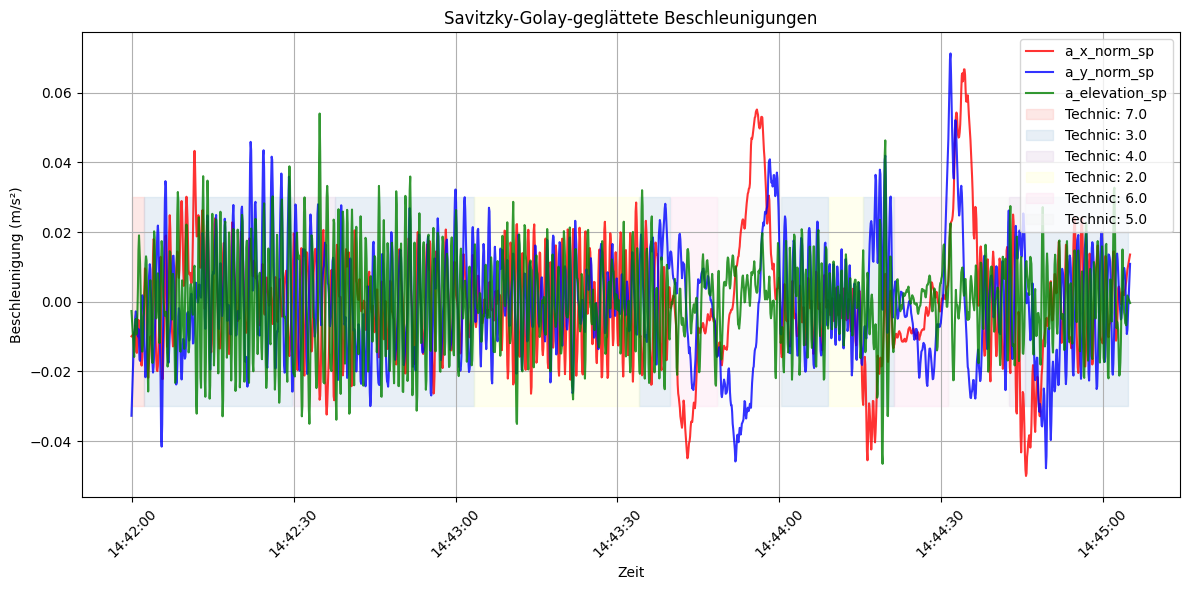

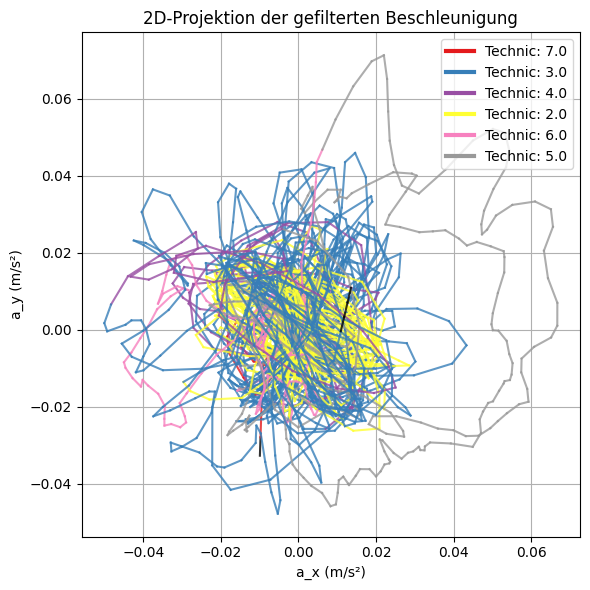

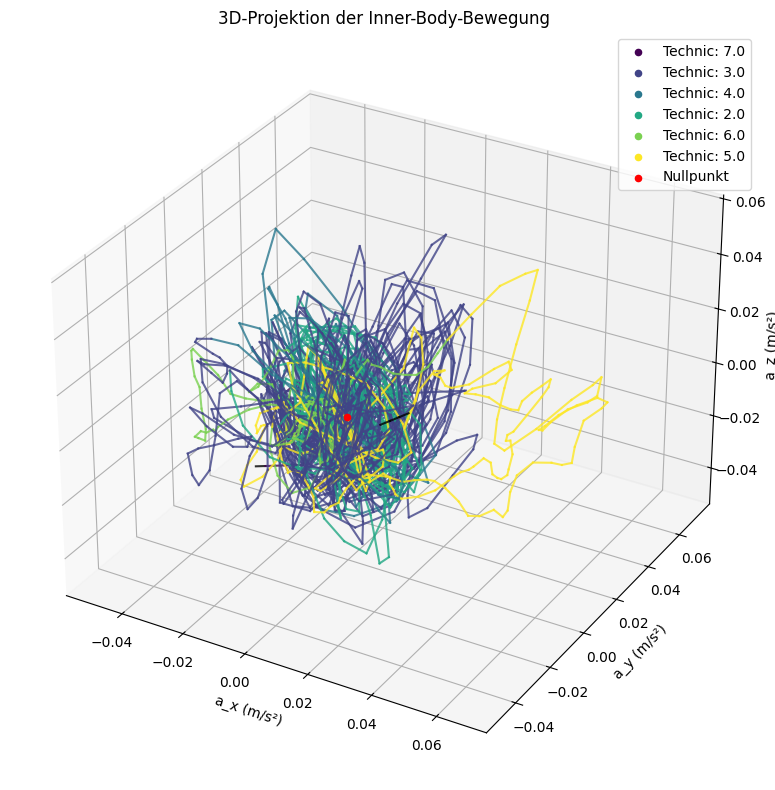

In [33]:
df = Savitzky_golay(df,filter_for=("x_norm","y_norm", "elevation"),window_size=11,order=3)


## Zeitreihe Beschleunigung Plotten

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def signal_projection(
    df: pd.DataFrame,
    signal_columns: tuple = ("a_x_norm_sp", "a_y_norm_sp", "a_elevation_sp"),
    plot: bool = True,
    plot_2d: bool = True,
    plot_3d: bool = True
) -> pd.DataFrame:
    """
    Visualisiert gegebene Beschleunigungssignale (ohne Savitzky-Golay).

    Args:
        df (pd.DataFrame): Eingabedaten mit gefilterten Spalten.
        signal_columns (tuple): Spaltennamen der Signale zur Anzeige.
        plot (bool): Zeitreihen-Plot anzeigen.
        plot_2d (bool): 2D-Projektionsplot.
        plot_3d (bool): 3D-Projektionsplot.

    Returns:
        pd.DataFrame: Unverändertes DataFrame.
    """
    # === Zeitreihenplot ===
    if plot:
        plt.figure(figsize=(12, 6))
        try:
            time_series = pd.to_datetime(df["time"], format="%H:%M:%S.%f")
        except:
            try:
                time_series = pd.to_datetime(df["time"])
            except:
                time_series = df.index

        colors = ["red", "blue", "green", "orange", "purple"]
        for i, col in enumerate(signal_columns):
            if col in df.columns:
                plt.plot(time_series, df[col], label=col, color=colors[i % len(colors)], alpha=0.8)

        if "technic" in df.columns:
            unique_technic = df["technic"].dropna().unique()
            technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
            technic_values = df["technic"].map(technic_mapping)
            bg_colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))

            for idx, (label, color) in enumerate(zip(technic_mapping.keys(), bg_colors)):
                mask = technic_values == idx
                plt.fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Technic: {label}")

        plt.xlabel("Zeit")
        plt.ylabel("Beschleunigung (m/s²)")
        plt.title("Sensorwerte (ungefiltert)")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # === 2D-Projektion ===
    if plot_2d and all(col in df.columns for col in signal_columns[:2]):
        x = df[signal_columns[0]]
        y = df[signal_columns[1]]
        technic = df["technic"] if "technic" in df.columns else None

        plt.figure(figsize=(6, 6))
        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.Set1(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                plt.plot(x[i:i+2], y[i:i+2], color=color, alpha=0.8)

            legend_patches = [
                plt.Line2D([0], [0], color=color, lw=3, label=f"Technic: {gear}")
                for gear, color in technic_mapping.items()
            ]
            plt.legend(handles=legend_patches, loc="upper right")
        else:
            plt.plot(x, y, color="blue", alpha=0.8)

        plt.scatter(0, 0, color="red", marker="o", label="Nullpunkt")
        plt.xlabel(signal_columns[0])
        plt.ylabel(signal_columns[1])
        plt.title("2D-Projektion der Sensorwerte")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # === 3D-Projektion ===
    if plot_3d and len(signal_columns) == 3 and all(col in df.columns for col in signal_columns):
        x = df[signal_columns[0]]
        y = df[signal_columns[1]]
        z = df[signal_columns[2]]
        technic = df["technic"] if "technic" in df.columns else None

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")

        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.viridis(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=color, alpha=0.8)

            for gear, color in technic_mapping.items():
                ax.scatter([], [], [], color=color, label=f"Technic: {gear}")
        else:
            ax.plot(x, y, z, color="blue", alpha=0.8)

        ax.scatter(0, 0, 0, color="red", marker="o", label="Nullpunkt")
        ax.set_xlabel(signal_columns[0])
        ax.set_ylabel(signal_columns[1])
        ax.set_zlabel(signal_columns[2])
        ax.set_title("3D-Projektion der Sensorwerte")
        ax.legend()
        plt.tight_layout()
        plt.show()

    return df


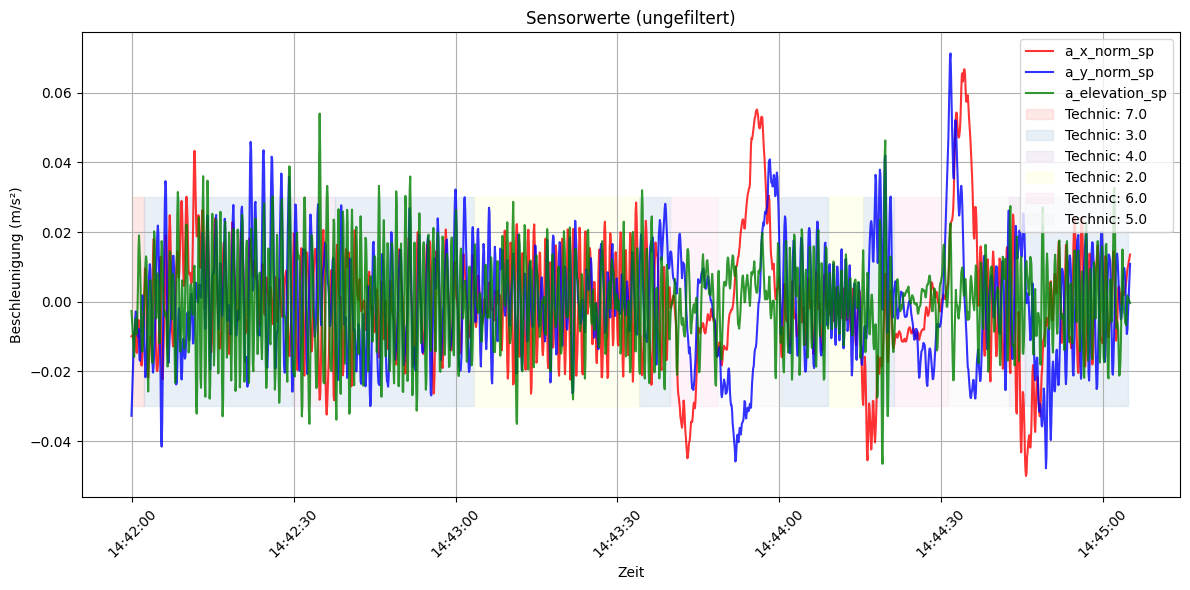

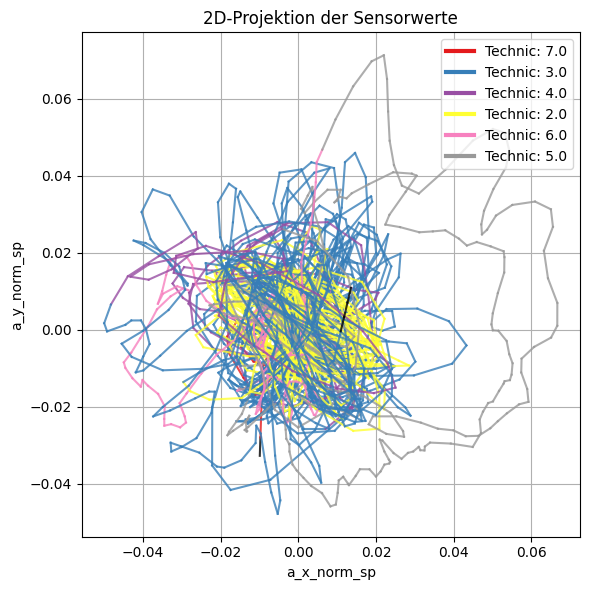

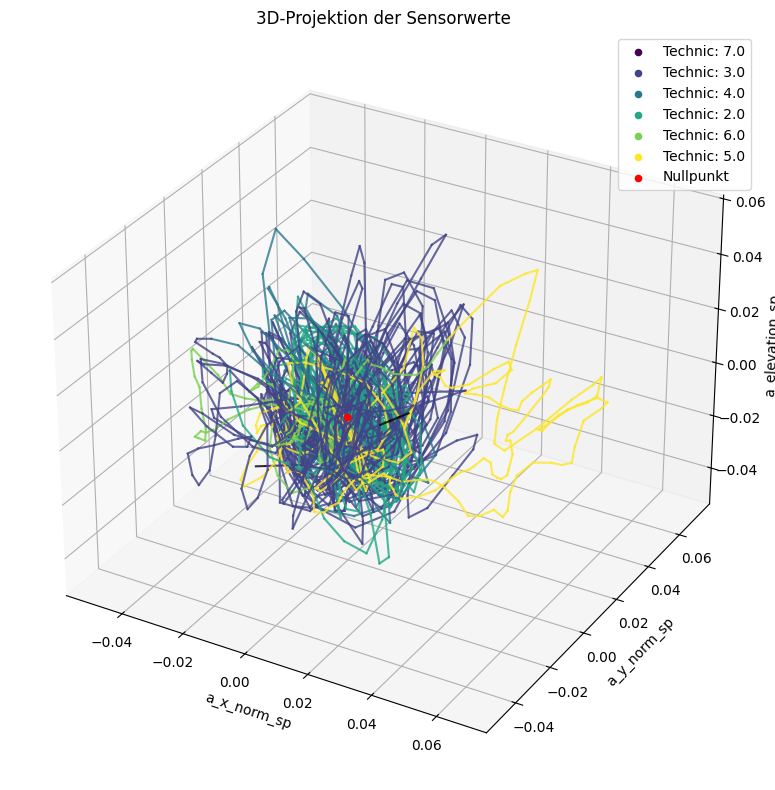

,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v,technic
0,46.500459,8.302499,1346.345,10.9,20240127T144159900000,XC,11783,14:41:59.9,2024-01-27,0.000000,...,NaN,NaN,NaN,0.000000,0.000000,2024-01-27 14:41:59.900,2024-01-27 14:41:59.900,0.0,0.000000,NaN
1,46.500458,8.302496,1346.570,11.6,20240127T144200000000,XC,11783,14:42:00.0,2024-01-27,-0.254880,...,0.000000,46.500459,8.302499,0.316037,0.315922,2024-01-27 14:42:00.000,2024-01-27 14:41:59.900,0.1,3.159216,7.0
2,46.500457,8.302493,1346.640,10.1,20240127T144200100000,XC,11783,14:42:00.1,2024-01-27,-0.478087,...,-0.186661,46.500458,8.302496,0.235817,0.235731,2024-01-27 14:42:00.100,2024-01-27 14:42:00.000,0.1,2.357315,7.0
3,46.500455,8.302488,1346.806,13.1,20240127T144200200000,XC,11783,14:42:00.2,2024-01-27,-0.825633,...,-0.262478,46.500457,8.302493,0.429754,0.429597,2024-01-27 14:42:00.200,2024-01-27 14:42:00.100,0.1,4.295972,7.0
4,46.500452,8.302484,1346.834,14.2,20240127T144200300000,XC,11783,14:42:00.3,2024-01-27,-1.173179,...,-0.514996,46.500455,8.302488,0.429754,0.429597,2024-01-27 14:42:00.300,2024-01-27 14:42:00.200,0.1,4.295972,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,46.500643,8.302157,1351.395,28.9,20240127T144504700000,XC,11783,14:45:04.7,2024-01-27,-26.015895,...,21.026178,46.500647,8.302167,0.816320,0.816022,2024-01-27 14:45:04.700,2024-01-27 14:45:04.600,0.1,8.160221,3.0
1849,46.500639,8.302149,1351.418,28.6,20240127T144504800000,XC,11783,14:45:04.8,2024-01-27,-26.687084,...,20.610106,46.500643,8.302157,0.784319,0.784033,2024-01-27 14:45:04.800,2024-01-27 14:45:04.700,0.1,7.840333,NaN
1850,46.500635,8.302140,1351.376,28.3,20240127T144504900000,XC,11783,14:45:04.9,2024-01-27,-27.358372,...,20.204874,46.500639,8.302149,0.790205,0.789917,2024-01-27 14:45:04.900,2024-01-27 14:45:04.800,0.1,7.899172,NaN
1851,46.500631,8.302131,1351.353,28.4,20240127T144505000000,XC,11783,14:45:05.0,2024-01-27,-28.022183,...,19.788531,46.500635,8.302140,0.795932,0.795642,2024-01-27 14:45:05.000,2024-01-27 14:45:04.900,0.1,7.956415,NaN


In [35]:
signal_projection(df, signal_columns=("a_x_norm_sp", "a_y_norm_sp", "a_elevation_sp"), plot=True, plot_2d=True, plot_3d=True)

## Strecke plotten (x, y)

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

def plot_technic_track(
    df: pd.DataFrame,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    technic_col: str = "technic"
):
    """
    Zeichnet eine durchgehende Strecke basierend auf lat/lon mit farblicher Unterscheidung der Techniken.
    Args:
        df (pd.DataFrame): DataFrame mit GPS-Daten.
        lat_col (str): Name der Latitude-Spalte.
        lon_col (str): Name der Longitude-Spalte.
        technic_col (str): Spalte zur Farbcodierung (optional).
    """
    if lat_col not in df.columns or lon_col not in df.columns:
        raise ValueError(f"Spalten '{lat_col}' oder '{lon_col}' fehlen im DataFrame.")

    lat = df[lat_col].to_numpy()
    lon = df[lon_col].to_numpy()

    # Erzeuge Liniensegmente (n-1 Stück)
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Farbwerte für jedes Segment
    if technic_col in df.columns and not df[technic_col].isna().all():
        technic_series = df[technic_col].ffill().bfill().to_numpy()
        unique_techs = pd.unique(technic_series)
        tech_mapping = {val: idx for idx, val in enumerate(unique_techs)}
        color_indices = np.array([tech_mapping[t] for t in technic_series])
        segment_colors = color_indices[:-1]
        colormap = plt.cm.Set1(np.linspace(0, 1, len(tech_mapping)))

        # Zeichne mit LineCollection
        fig, ax = plt.subplots(figsize=(14, 7))
        lc = LineCollection(segments, colors=[colormap[i] for i in segment_colors], linewidth=2)
        ax.add_collection(lc)

        # Achsenlimits
        ax.set_xlim(lon.min(), lon.max())
        ax.set_ylim(lat.min(), lat.max())

        # Legende manuell erstellen
        legend_elements = [
            Line2D([0], [0], color=colormap[i], lw=3, label=str(label))
            for label, i in tech_mapping.items()
        ]
        ax.legend(handles=legend_elements, title="Technic")

    else:
        # Fallback: Einfarbige Strecke
        plt.plot(lon, lat, color="black", linewidth=2, label="Strecke")
        plt.legend()

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Strecke mit Technic-Färbung (wenn vorhanden)")
    ax.grid(True)
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()


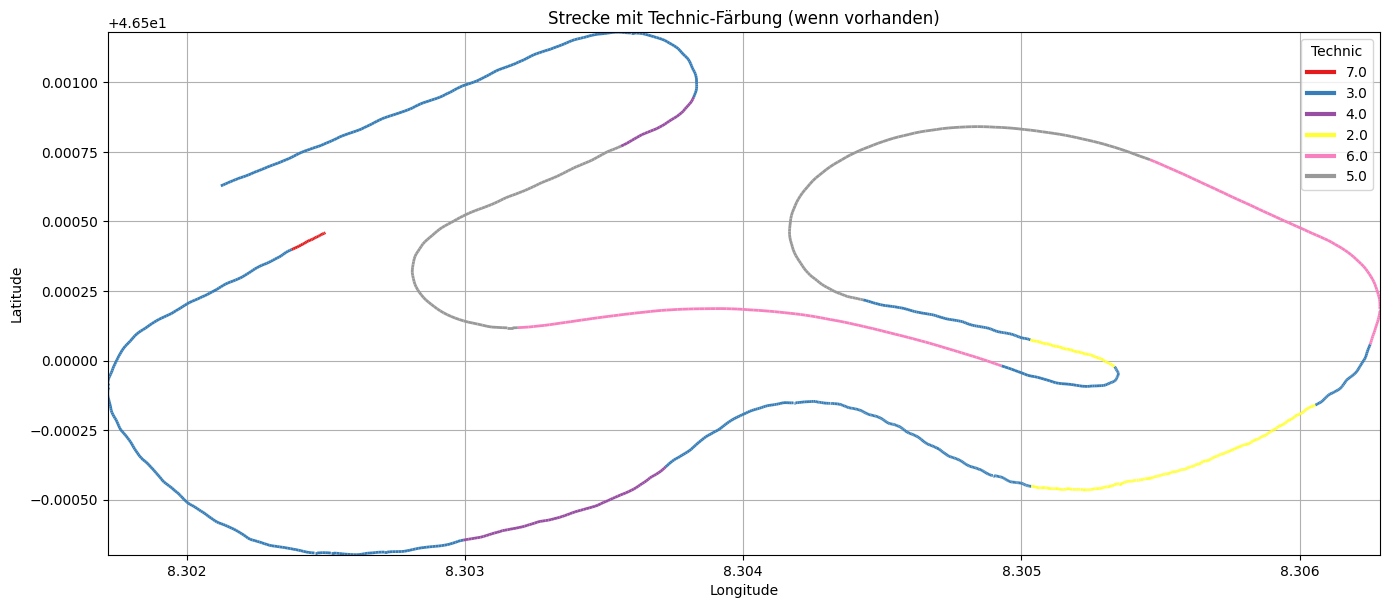

In [37]:
plot_technic_track(df, lat_col="latitude", lon_col="longitude", technic_col="technic")


# Testdaten erzeugen (Halbkreis mit Innerbody)



*   Ziel a_lr/a_vz
*   Lattitude / Longitude



In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_testdata_MB(R: float, V: float, show_plot: bool = True) -> pd.DataFrame:
    """
    Erzeugt Testdaten zur Körperbewegung auf einer Kreisbahn mit Schwerpunkt- und Schwankungsbewegung.

    Args:
        R (float): Radius der Kurve in Metern.
        V (float): Geschwindigkeit in m/s.
        show_plot (bool): Wenn True, wird die Bewegung visualisiert.

    Returns:
        pd.DataFrame: Enthält t, Schwerpunkt, Körperbewegung, Winkel, Schwankungen und Streckenlänge.
    """
    omega = V / R
    t = np.linspace(0, 2 * np.pi, num=500)

    # Schwerpunktbewegung (ideale Kreisbahn)
    x_sp = R * np.cos(omega * t)
    y_sp = R * np.sin(omega * t)
    phi = omega * t

    # Schwankungen simulieren
    omega_inner = 2 * np.pi / 5
    x_LR = 0.2 * np.sin(omega_inner * t)
    y_vz = 0.5 * np.sin(omega_inner * t)

    # Körperbewegung mit Schwankung
    x = x_sp + x_LR * np.cos(phi) - y_vz * np.sin(phi)
    y = y_sp + x_LR * np.sin(phi) + y_vz * np.cos(phi)

    # DataFrame
    df = pd.DataFrame({
        "t": t,
        "x_sp": x_sp,
        "y_sp": y_sp,
        "x": x,
        "y": y,
        "phi": phi,
        "x_LR": x_LR,
        "y_vz": y_vz,
        "streckenlänge": np.pi * R
    })

    # Plot
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Plot 1 – Linien
        axes[0].plot(df["x_sp"], df["y_sp"], color="blue", linestyle="--", label="Schwerpunkt")
        axes[0].plot(df["x"], df["y"], color="red", linestyle="-", alpha=0.7, label="Körperbewegung")
        axes[0].scatter(df["x_sp"].iloc[0], df["y_sp"].iloc[0], color="green", label="Start", zorder=3, s=50)
        axes[0].scatter(df["x_sp"].iloc[-1], df["y_sp"].iloc[-1], color="red", label="Ende", zorder=3, s=50)
        axes[0].set_xlabel("X (Querbewegung in Meter)")
        axes[0].set_ylabel("Y (Vorwärtsbewegung in Meter)")
        axes[0].set_title("Schwerpunkt vs. Körperbewegung (Linien)")
        axes[0].legend()
        axes[0].grid(True, linestyle="--", linewidth=0.5)

        # Plot 2 – Punkte
        axes[1].scatter(df["x_sp"], df["y_sp"], color="blue", label="Schwerpunkt", s=2)
        axes[1].scatter(df["x"], df["y"], color="red", label="Körperbewegung", s=2)
        axes[1].scatter(df["x_sp"].iloc[0], df["y_sp"].iloc[0], color="green", label="Start", zorder=3, s=50)
        axes[1].scatter(df["x_sp"].iloc[-1], df["y_sp"].iloc[-1], color="red", label="Ende", zorder=3, s=50)
        axes[1].set_xlabel("X (Querbewegung in Meter)")
        axes[1].set_ylabel("Y (Vorwärtsbewegung in Meter)")
        axes[1].set_title("Echte Punkte (Diskret)")
        axes[1].legend()
        axes[1].grid(True, linestyle="--", linewidth=0.5)

        plt.tight_layout()
        plt.show()

    return df


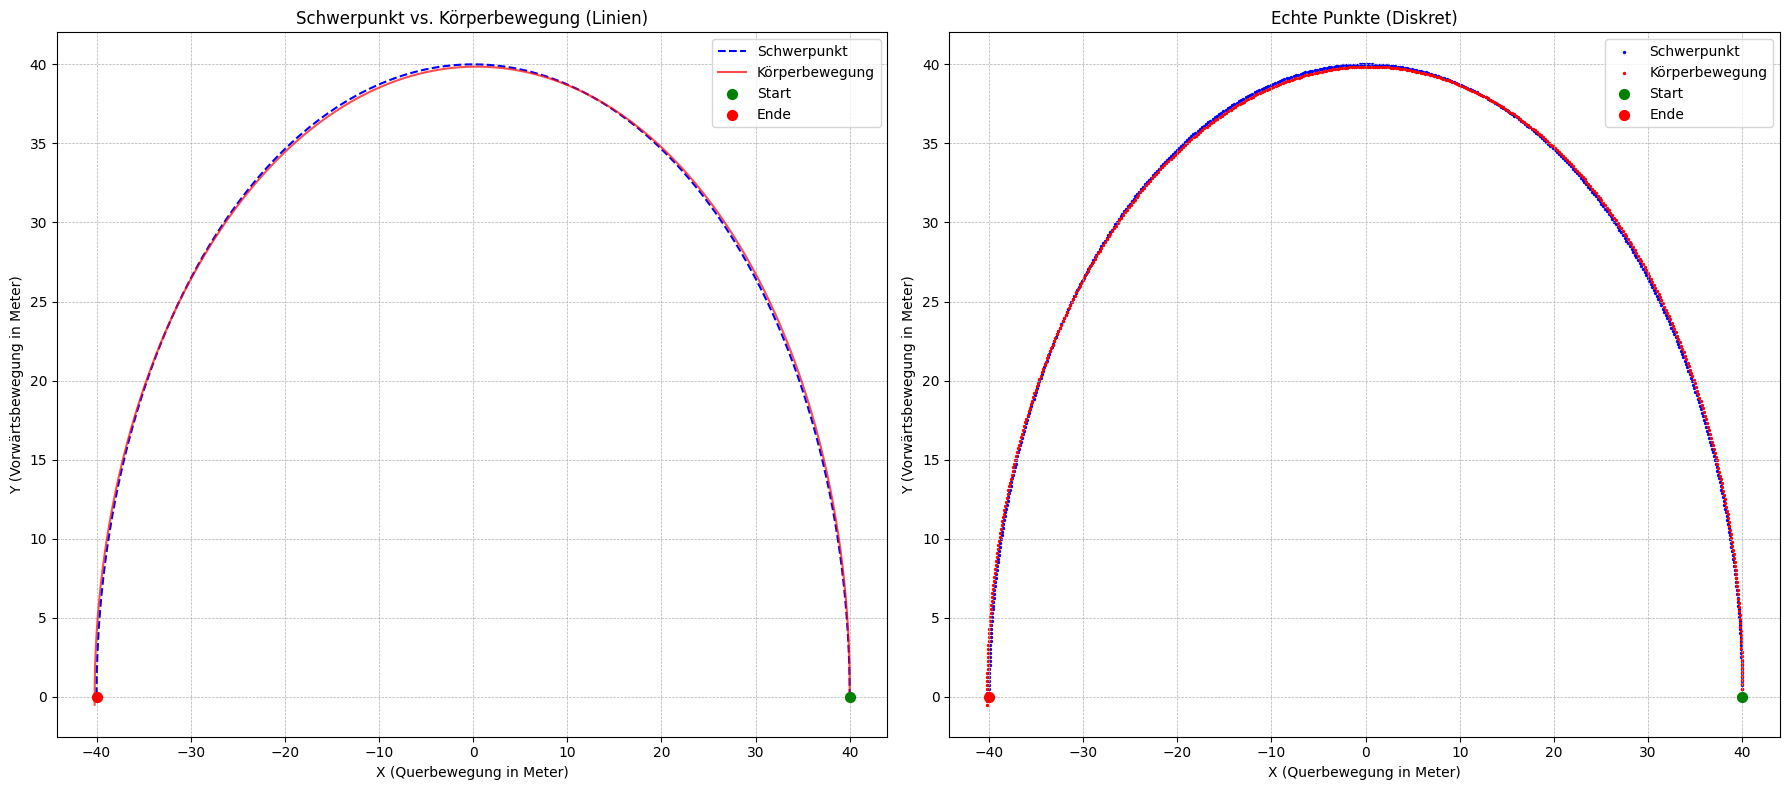

In [39]:
MB_test = generate_testdata_MB(R=40, V=20)


In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_testdata_LOF(
    R: float,
    V: float,
    periods: int = 24,
    A_xLR: float = 0.8,
    A_yVZ: float = 1.0,
    show_plot: bool = True
) -> pd.DataFrame:
    """
    Erzeugt Testdaten mit starker Körperbewegung (LOF) über eine Kreisbahn.

    Args:
        R (float): Radius der Kreisbahn in Metern.
        V (float): Geschwindigkeit in m/s.
        periods (int): Anzahl innerer Schwankungsperioden.
        A_xLR (float): Amplitude der seitlichen Kippbewegung.
        A_yVZ (float): Amplitude der Vorwärtsschwankung.
        show_plot (bool): Ob die Visualisierung angezeigt werden soll.

    Returns:
        pd.DataFrame: Testdaten mit Schwerpunkt- & Körperbewegung.
    """
    omega = V / R
    t = np.linspace(0, 7, num=70)
    phi = omega * t

    # Schwerpunkt
    x_sp = R * np.cos(omega * t)
    y_sp = R * np.sin(omega * t)

    # Schwankungen
    omega_inner = omega * periods
    x_LR = A_xLR * np.sin(omega_inner * t)
    y_vz = A_yVZ * np.sin(omega_inner * t)

    # Körperbewegung
    x = x_sp + x_LR * np.cos(phi) - y_vz * np.sin(phi)
    y = y_sp + x_LR * np.sin(phi) + y_vz * np.cos(phi)

    # DataFrame
    df = pd.DataFrame({
        "t": t,
        "x_sp_echt": x_sp,
        "y_sp_echt": y_sp,
        "x": x,
        "y": y,
        "phi": phi,
        "x_LR": x_LR,
        "y_vz": y_vz,
        "streckenlänge": np.pi * R
    })

    # Plot
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Plot 1 – Linien
        axes[0].plot(df["x_sp_echt"], df["y_sp_echt"], color="blue", linestyle="--", label="Schwerpunkt")
        axes[0].plot(df["x"], df["y"], color="red", linestyle="-", alpha=0.7, label="Körperbewegung")
        axes[0].scatter(df["x_sp_echt"].iloc[0], df["y_sp_echt"].iloc[0], color="green", label="Start", zorder=3, s=50)
        axes[0].scatter(df["x_sp_echt"].iloc[-1], df["y_sp_echt"].iloc[-1], color="red", label="Ende", zorder=3, s=50)
        axes[0].set_xlabel("X (Querbewegung in Meter)")
        axes[0].set_ylabel("Y (Vorwärtsbewegung in Meter)")
        axes[0].set_title("Schwerpunkt vs. Körperbewegung (Linien)")
        axes[0].legend()
        axes[0].grid(True, linestyle="--", linewidth=0.5)

        # Plot 2 – Punkte
        axes[1].scatter(df["x_sp_echt"], df["y_sp_echt"], color="blue", label="Schwerpunkt", s=2)
        axes[1].scatter(df["x"], df["y"], color="red", label="Körperbewegung", s=2)
        axes[1].scatter(df["x_sp_echt"].iloc[0], df["y_sp_echt"].iloc[0], color="green", label="Start", zorder=3, s=50)
        axes[1].scatter(df["x_sp_echt"].iloc[-1], df["y_sp_echt"].iloc[-1], color="red", label="Ende", zorder=3, s=50)
        axes[1].set_xlabel("X (Querbewegung in Meter)")
        axes[1].set_ylabel("Y (Vorwärtsbewegung in Meter)")
        axes[1].set_title("Echte Punkte (Diskret)")
        axes[1].legend()
        axes[1].grid(True, linestyle="--", linewidth=0.5)

        plt.tight_layout()
        plt.show()

        df["technic"] = "1"

    return df


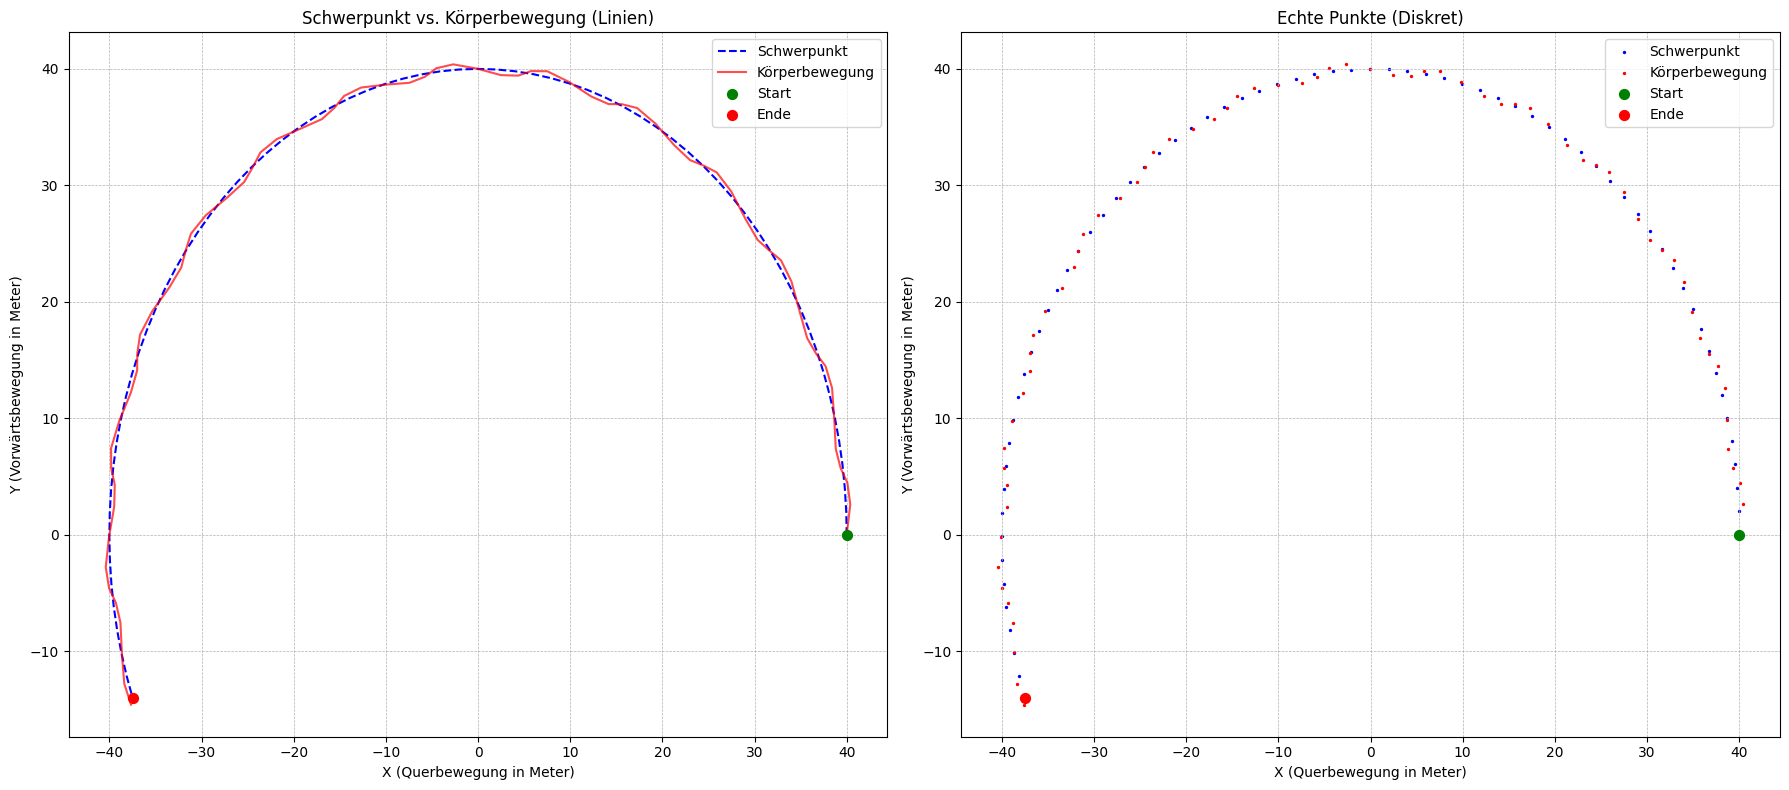

In [120]:
df_lof = generate_testdata_LOF(R=40, V=20, periods=24, A_xLR=0.5, A_yVZ=0.6)

In [121]:
df_lof

,t,x_sp_echt,y_sp_echt,x,y,phi,x_LR,y_vz,streckenlänge,technic
0,0.000000,40.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,125.663706,1
1,0.101449,39.948551,2.028116,40.388506,2.614096,0.050725,0.469100,0.562920,125.663706,1
2,0.202899,39.794337,4.051014,40.077912,4.471542,0.101449,0.324706,0.389647,125.663706,1
3,0.304348,39.537755,6.063491,39.340683,5.736630,0.152174,-0.244342,-0.293211,125.663706,1
4,0.405797,39.179464,8.060371,38.815173,7.380410,0.202899,-0.493837,-0.592604,125.663706,1
...,...,...,...,...,...,...,...,...,...,...
65,6.594203,-39.517314,-6.195311,-39.293987,-5.822093,3.297101,-0.278437,-0.334125,125.663706,1
66,6.695652,-39.152366,-8.190984,-38.796091,-7.520625,3.347826,-0.485998,-0.583198,125.663706,1
67,6.797101,-38.686701,-10.165587,-38.648317,-10.083581,3.398551,-0.057965,-0.069558,125.663706,1
68,6.898551,-38.121517,-12.114039,-38.384413,-12.758997,3.449275,0.445875,0.535051,125.663706,1


# Datensatz kofigurieren

In [43]:
# Erforderliche Bibliotheken erneut importieren
from datetime import datetime, timedelta
from geopy.distance import geodesic

# **Funktion zur Umwandlung der Testdaten in das gewünschte GPS-Format mit initial_timestamp & timedelta Korrektur**
def convert_to_gps_format(df_testdata, start_lat=46.500480, start_lon=8.302427, elevation_base=1350, tf_id=11783):
    """
    Wandelt x/y-Meterwerte aus df_testdata in realistische GPS-Koordinaten (Latitude/Longitude) um.
    Berechnet Geschwindigkeit, Höhe und fügt Zeitstempel hinzu.

    Parameter:
    df_testdata (DataFrame): Enthält die simulierten Testdaten mit x, y, t.
    start_lat (float): Startlatitude für die GPS-Umrechnung.
    start_lon (float): Startlongitude für die GPS-Umrechnung.
    elevation_base (float): Basishöhe in Metern.
    tf_id (int): ID für die GPS-Daten.

    Rückgabe:
    DataFrame: Formatierte GPS-Daten mit Geschwindigkeit, Höhe und Timestamps.
    """

    # **1️⃣ Startzeitpunkt bestimmen (jetzt explizit innerhalb der Funktion definiert)**
    initial_timestamp = datetime.now()  # Setzt den Startzeitpunkt auf die aktuelle Zeit

    # **2️⃣ Umrechnung der X- und Y-Werte in echte Längen-/Breitengrade**
    latitude_corrected = []
    longitude_corrected = []

    for _, row in df_testdata.iterrows():
        # Berechnung der neuen GPS-Koordinaten relativ zum Startpunkt
        new_lat = geodesic(meters=row["y"]).destination((start_lat, start_lon), 0).latitude
        new_lon = geodesic(meters=row["x"]).destination((start_lat, start_lon), 90).longitude

        latitude_corrected.append(new_lat)
        longitude_corrected.append(new_lon)

    # **3️⃣ Geschwindigkeit berechnen (Ableitung der Strecke nach Zeit)**
    dt = np.diff(df_testdata["t"], prepend=df_testdata["t"].iloc[0])  # Zeitschritt
    dx = np.diff(df_testdata["x"], prepend=df_testdata["x"].iloc[0])
    dy = np.diff(df_testdata["y"], prepend=df_testdata["y"].iloc[0])

    # Verhindere Division durch 0 für den ersten Zeitschritt
    dt[dt == 0] = np.nan
    speed_measured = np.sqrt(dx**2 + dy**2) / dt  # Geschwindigkeit = Strecke / Zeit

    # **4️⃣ Erstellen des neuen DataFrames mit echten GPS-Koordinaten**
    df_final = pd.DataFrame({
        "latitude": latitude_corrected,
        "longitude": longitude_corrected,
        "elevation": elevation_base + 0.5 * np.sin(df_testdata["phi"]),  # Leichte Höhenvariation für Realismus
        "speed_measured": speed_measured,  # Berechnete Geschwindigkeit
        "timestamp": [(initial_timestamp + timedelta(seconds=float(t))).isoformat() + "000" for t in df_testdata["t"]],  # ISO-Timestamp
        "discipline_from_name": "XC",  # Konstante Spalte
        "tf_id": tf_id  # Konstante ID

    })
    df_final["technic"]= "1"
    # **5️⃣ NaN-Werte in "speed_measured" entfernen (durch Interpolation ersetzen)**
    df_final["speed_measured"] = df_final["speed_measured"].interpolate(method='linear')

    # **6️⃣ Erste Zeile mit NaN-Wert entfernen (falls vorhanden)**
    df_final = df_final.dropna(subset=["speed_measured"]).reset_index(drop=True)

    # **7️⃣ Timestamp-Format korrigieren**
    df_final["timestamp"] = df_final["timestamp"].apply(
        lambda x: datetime.strptime(x[:23], "%Y-%m-%dT%H:%M:%S.%f").strftime("%Y%m%dT%H%M%S%f")[:-3]  # Entfernt letzte 3 Stellen für Millisekundenpräzision
    )
    xc = SkiCrossCountry(df=df_final)
    df_final = xc.compute()



    return df_final

In [44]:
df_lof = convert_to_gps_format(df_lof)
df_lof

2025-04-08 11:58:00.051 | INFO     | __main__:_compute_xc_specific_physical_size:20 - xc specific


,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,technic,time,date,...,shifted_x_norm,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v
0,46.500483,8.302949,1350.003148,27.835738,20250408T115753568,XC,11783,1,11:57:53.5,2025-04-08,...,NaN,NaN,NaN,NaN,0.000000,0.000000,2025-04-08 11:57:53.500,2025-04-08 11:57:53.500,0.0,0.000000
1,46.500486,8.302950,1350.006296,27.674136,20250408T115753580,XC,11783,1,11:57:53.5,2025-04-08,...,0.000000,0.000000,46.500483,8.302949,0.348460,0.348333,2025-04-08 11:57:53.500,2025-04-08 11:57:53.500,0.0,0.000000
2,46.500489,8.302951,1350.009443,27.329141,20250408T115753593,XC,11783,1,11:57:53.5,2025-04-08,...,0.072463,0.340713,46.500486,8.302950,0.344116,0.343991,2025-04-08 11:57:53.500,2025-04-08 11:57:53.500,0.0,0.000000
3,46.500492,8.302952,1350.012590,26.811212,20250408T115753606,XC,11783,1,11:57:53.6,2025-04-08,...,0.138872,0.678232,46.500489,8.302951,0.337595,0.337472,2025-04-08 11:57:53.600,2025-04-08 11:57:53.500,0.1,3.374716
4,46.500495,8.302952,1350.015737,26.135759,20250408T115753618,XC,11783,1,11:57:53.6,2025-04-08,...,0.197731,1.010532,46.500492,8.302952,0.329090,0.328970,2025-04-08 11:57:53.600,2025-04-08 11:57:53.600,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,46.500492,8.301910,1350.012590,25.894764,20250408T115759788,XC,11783,1,11:57:59.7,2025-04-08,...,-79.654663,2.019797,46.500495,8.301911,0.326055,0.325936,2025-04-08 11:57:59.700,2025-04-08 11:57:59.700,0.0,0.000000
495,46.500489,8.301909,1350.009443,26.622907,20250408T115759801,XC,11783,1,11:57:59.8,2025-04-08,...,-79.727556,1.702116,46.500492,8.301910,0.335224,0.335101,2025-04-08 11:57:59.800,2025-04-08 11:57:59.700,0.1,3.351015
496,46.500486,8.301908,1350.006296,27.194236,20250408T115759813,XC,11783,1,11:57:59.8,2025-04-08,...,-79.804702,1.376015,46.500489,8.301909,0.342418,0.342293,2025-04-08 11:57:59.800,2025-04-08 11:57:59.800,0.0,0.000000
497,46.500483,8.301907,1350.003148,27.593050,20250408T115759826,XC,11783,1,11:57:59.8,2025-04-08,...,-79.884425,1.043136,46.500486,8.301908,0.347439,0.347313,2025-04-08 11:57:59.800,2025-04-08 11:57:59.800,0.0,0.000000


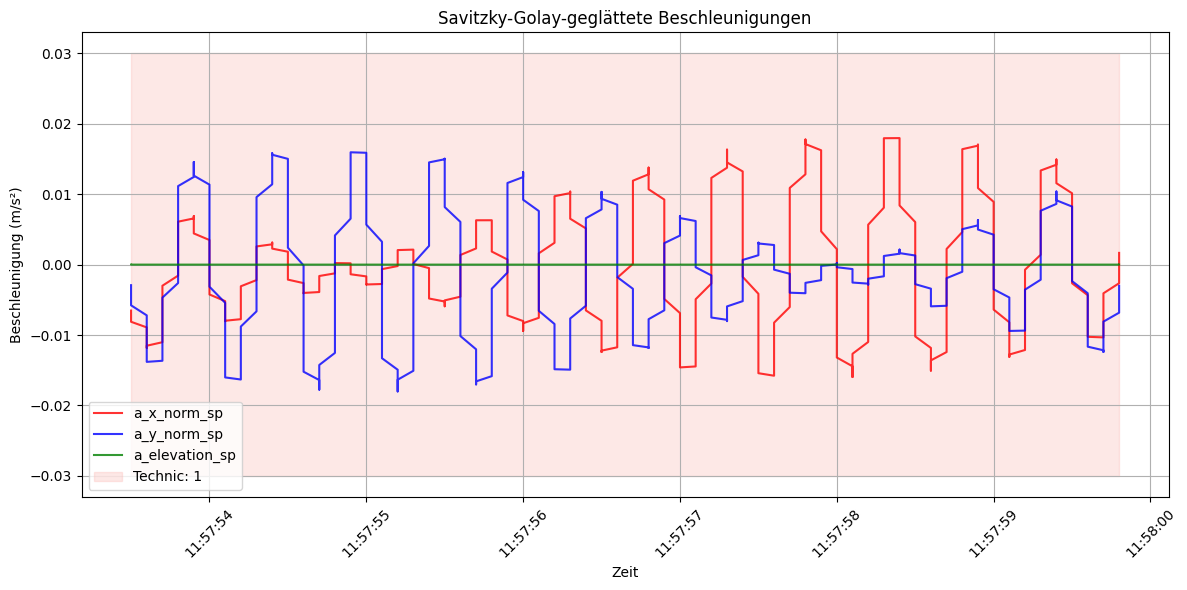

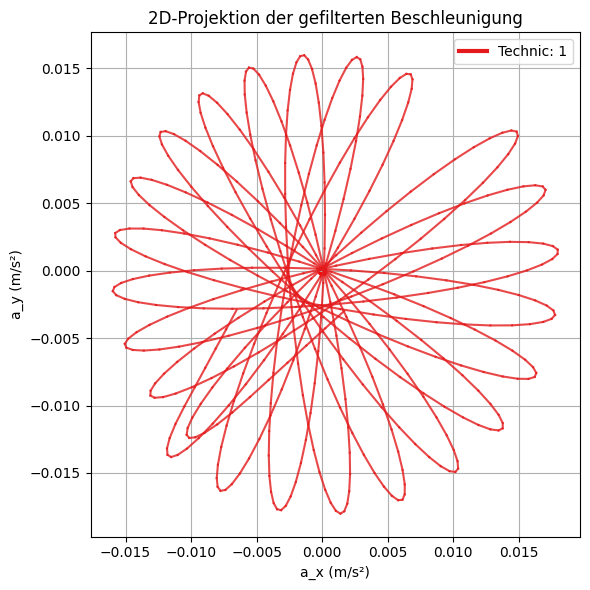

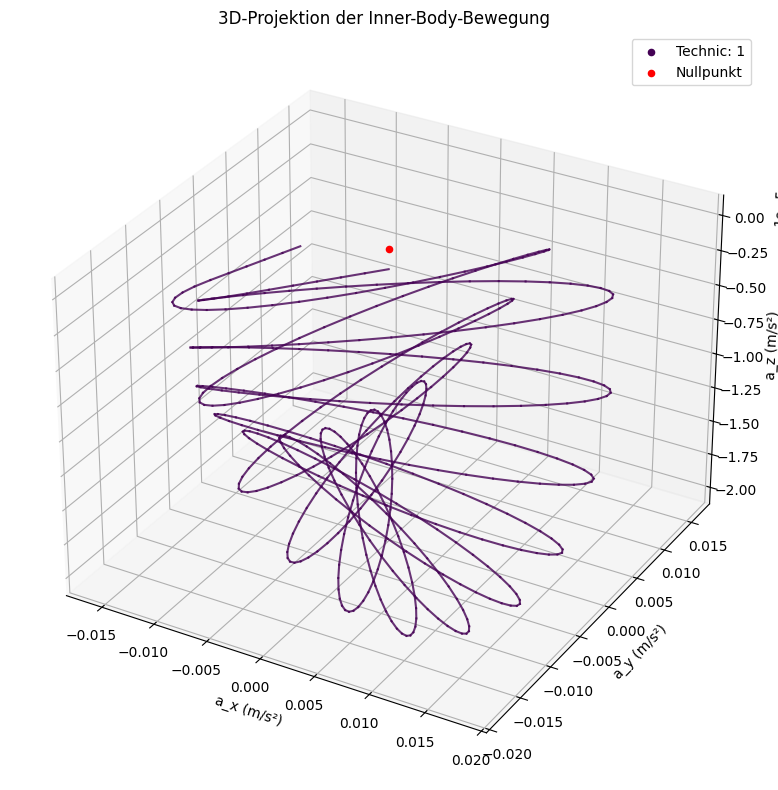

In [45]:
df_lof = Savitzky_golay(df_lof,filter_for=("x_norm","y_norm", "elevation"),window_size=11,order=3)

# Vorwärtsbewegung Euklidisch

In [46]:
df_lof

,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,technic,time,date,...,shifted_x_norm,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v
0,46.500483,8.302949,1350.003148,27.835738,20250408T115753568,XC,11783,1,11:57:53.5,2025-04-08,...,NaN,NaN,NaN,NaN,0.000000,0.000000,2025-04-08 11:57:53.500,2025-04-08 11:57:53.500,0.0,0.000000
1,46.500486,8.302950,1350.006296,27.674136,20250408T115753580,XC,11783,1,11:57:53.5,2025-04-08,...,0.000000,0.000000,46.500483,8.302949,0.348460,0.348333,2025-04-08 11:57:53.500,2025-04-08 11:57:53.500,0.0,0.000000
2,46.500489,8.302951,1350.009443,27.329141,20250408T115753593,XC,11783,1,11:57:53.5,2025-04-08,...,0.072463,0.340713,46.500486,8.302950,0.344116,0.343991,2025-04-08 11:57:53.500,2025-04-08 11:57:53.500,0.0,0.000000
3,46.500492,8.302952,1350.012590,26.811212,20250408T115753606,XC,11783,1,11:57:53.6,2025-04-08,...,0.138872,0.678232,46.500489,8.302951,0.337595,0.337472,2025-04-08 11:57:53.600,2025-04-08 11:57:53.500,0.1,3.374716
4,46.500495,8.302952,1350.015737,26.135759,20250408T115753618,XC,11783,1,11:57:53.6,2025-04-08,...,0.197731,1.010532,46.500492,8.302952,0.329090,0.328970,2025-04-08 11:57:53.600,2025-04-08 11:57:53.600,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,46.500492,8.301910,1350.012590,25.894764,20250408T115759788,XC,11783,1,11:57:59.7,2025-04-08,...,-79.654663,2.019797,46.500495,8.301911,0.326055,0.325936,2025-04-08 11:57:59.700,2025-04-08 11:57:59.700,0.0,0.000000
495,46.500489,8.301909,1350.009443,26.622907,20250408T115759801,XC,11783,1,11:57:59.8,2025-04-08,...,-79.727556,1.702116,46.500492,8.301910,0.335224,0.335101,2025-04-08 11:57:59.800,2025-04-08 11:57:59.700,0.1,3.351015
496,46.500486,8.301908,1350.006296,27.194236,20250408T115759813,XC,11783,1,11:57:59.8,2025-04-08,...,-79.804702,1.376015,46.500489,8.301909,0.342418,0.342293,2025-04-08 11:57:59.800,2025-04-08 11:57:59.800,0.0,0.000000
497,46.500483,8.301907,1350.003148,27.593050,20250408T115759826,XC,11783,1,11:57:59.8,2025-04-08,...,-79.884425,1.043136,46.500486,8.301908,0.347439,0.347313,2025-04-08 11:57:59.800,2025-04-08 11:57:59.800,0.0,0.000000


In [47]:
def smooth_and_euklid(df: pd.DataFrame, window_size: int = 91, order: int = 3) -> pd.DataFrame:
    df_mod = df.copy()

    # === 1. Glätten ===
    df_mod["latitude_smooth"] = savgol_filter(df_mod["latitude"], window_size, order)
    df_mod["longitude_smooth"] = savgol_filter(df_mod["longitude"], window_size, order)

    # === 2. Tangentenwinkel
    dx = np.diff(df_mod["longitude_smooth"])
    dy = np.diff(df_mod["latitude_smooth"])
    phi = np.arctan2(dy, dx)
    phi = np.append(phi, phi[-1])
    df_mod["phi_tangent"] = phi
    df_mod["phi_tangent_deg"] = np.degrees(phi)

    # === 3. Neue Richtung
    df_mod["dx"] = df_mod["longitude"].diff()
    df_mod["dy"] = df_mod["latitude"].diff()
    df_mod["distance"] = np.sqrt(df_mod["dx"]**2 + df_mod["dy"]**2)

    phi_rad = np.radians(df_mod["phi_tangent"])
    df_mod["dx_new"] = df_mod["distance"] * np.cos(phi_rad)
    df_mod["dy_new"] = df_mod["distance"] * np.sin(phi_rad)

    df_mod["longitude_new"] = df_mod["longitude"].iloc[0] + np.cumsum(df_mod["dx_new"].fillna(0))
    df_mod["latitude_new"] = df_mod["latitude"].iloc[0] + np.cumsum(df_mod["dy_new"].fillna(0))



    # === Plot 1: Original
    plt.figure(figsize=(10, 6))
    plt.plot(df_mod["longitude"], df_mod["latitude"], label="Original", color="black", linewidth=1)
    plt.scatter(df_mod["longitude"].iloc[0], df_mod["latitude"].iloc[0], color="green", label="Start", s=60)
    plt.scatter(df_mod["longitude"].iloc[-1], df_mod["latitude"].iloc[-1], color="red", label="Ende", s=60)
    plt.title("Originale GPS-Strecke")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


    # === Plot 2: Geglättet (Savitzky-Golay)
    plt.figure(figsize=(10, 6))
    plt.plot(df_mod["longitude_smooth"], df_mod["latitude_smooth"], label="Geglättet (Savitzky-Golay)", color="blue", linewidth=1)
    plt.scatter(df_mod["longitude_smooth"].iloc[0], df_mod["latitude_smooth"].iloc[0], color="green", label="Start", s=60)
    plt.scatter(df_mod["longitude_smooth"].iloc[-1], df_mod["latitude_smooth"].iloc[-1], color="red", label="Ende", s=60)
    plt.title("Geglättete GPS-Strecke (Savitzky-Golay)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


    # === Plot 2: Original vs. Rekonstruiert via Tangente
    plt.figure(figsize=(10, 6))
    plt.plot(df_mod["longitude"], df_mod["latitude"], label="Original", color="black", linewidth=1)
    plt.plot(df_mod["longitude_new"], df_mod["latitude_new"], label="Rekonstruiert (Tangente)", color="red", linewidth=1)
    plt.scatter(df_mod["longitude"].iloc[0], df_mod["latitude"].iloc[0], color="green", label="Start", s=60)
    plt.scatter(df_mod["longitude"].iloc[-1], df_mod["latitude"].iloc[-1], color="red", label="Ende", s=60)
    plt.title("Original vs. Rekonstruiert via Tangente")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()






    # === 5. Koordinaten ersetzen
    df_mod["longitude"] = df_mod["longitude_new"]
    df_mod["latitude"] = df_mod["latitude_new"]
    df_mod = df_mod.drop(columns=["longitude_new", "latitude_new"])

    # === 6. Drop NaNs (nur zur Sicherheit)
    df_mod = df_mod.dropna(subset=["latitude", "longitude"])

    # === 7. Modellberechnung
    xc = SkiCrossCountry(df=df_mod)
    df_mod = xc.compute()

    # === 8. Ausgabe
    print("Erkannte Techniken:", df_mod["technic"].unique())
    return df_mod


In [48]:
df_lof = convert_to_gps_format(df_lof)

KeyError: 'y'

In [ ]:
df_lof = smooth_and_euklid(df_lof, window_size=91)

In [ ]:
plot_technic_track(df_lof, lat_col="latitude", lon_col="longitude", technic_col="technic")

# Test Vorwärtsbewegung_Ableitung

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

def Smooth_and_acceleration(df: pd.DataFrame, window_size: int = 91, order: int = 3) -> pd.DataFrame:
    """
    Glättet GPS-Daten, berechnet Tangentenwinkel, rotiert Beschleunigungen,
    und visualisiert alles inkl. 3D-Plot pro Gear.
    """

    df_mod = df.copy()

    # === 1. GPS Glätten ===
    df_mod["latitude_smooth"] = savgol_filter(df_mod["latitude"], window_size, order)
    df_mod["longitude_smooth"] = savgol_filter(df_mod["longitude"], window_size, order)

    df_modified_Stan = df_mod.copy()



    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    # Original GPS-Strecke
    ax[0].plot(df_modified_Stan["longitude"], df_modified_Stan["latitude"], color="black", linestyle="-", alpha=1, linewidth=1)
    ax[0].scatter(df_modified_Stan["longitude"].iloc[0], df_modified_Stan["latitude"].iloc[0], color="green", label="Start", zorder=3, s=80)
    ax[0].scatter(df_modified_Stan["longitude"].iloc[-1], df_modified_Stan["latitude"].iloc[-1], color="red", label="Ende", zorder=3, s=80)
    ax[0].set_title("Originale GPS-Strecke", fontsize=14)
    ax[0].set_xlabel("Longitude (Längengrad)", fontsize=12)
    ax[0].set_ylabel("Latitude (Breitengrad)", fontsize=12)
    ax[0].legend()
    ax[0].grid(True, linestyle="--", linewidth=0.5)

    # Geglättete GPS-Strecke
    ax[1].plot(df_modified_Stan["longitude_smooth"], df_modified_Stan["latitude_smooth"], color="blue", linestyle="-", linewidth=1, label="Geglättet")
    ax[1].scatter(df_modified_Stan["longitude"].iloc[0], df_modified_Stan["latitude"].iloc[0], color="green", label="Start", zorder=3, s=80)
    ax[1].scatter(df_modified_Stan["longitude"].iloc[-1], df_modified_Stan["latitude"].iloc[-1], color="red", label="Ende", zorder=3, s=80)
    ax[1].set_title("Geglättete GPS-Strecke (Savitzky-Golay 91)", fontsize=14)
    ax[1].set_xlabel("Longitude (Längengrad)", fontsize=12)
    ax[1].legend()
    ax[1].grid(True, linestyle="--", linewidth=0.5)


    # Gemeinsame Achsenbegrenzung für besseren Vergleich
    for a in ax:
        a.set_xlim(df_modified_Stan["longitude"].min() - 0.0002, df_modified_Stan["longitude"].max() + 0.0002)
        a.set_ylim(df_modified_Stan["latitude"].min() - 0.0002, df_modified_Stan["latitude"].max() + 0.0002)

    # Anzeigen der Plots
    plt.tight_layout()
    plt.show()


    # === 2. Winkel (phi_tangent) berechnen
    dx = np.diff(df_mod["longitude_smooth"])
    dy = np.diff(df_mod["latitude_smooth"])
    phi = np.arctan2(dy, dx)
    phi = np.append(phi, phi[-1])  # Länge anpassen
    df_mod["phi_tangent"] = phi
    df_mod["phi_tangent_deg"] = np.degrees(phi)
    df_mod["phi_tangent_rad"] = np.radians(df_mod["phi_tangent_deg"])

    # === 3. Beschleunigungen rotieren (falls vorhanden)
    if "a_x_norm_sp" in df_mod.columns and "a_y_norm_sp" in df_mod.columns:
        def rotate(ax, ay, phi_rad):
            cos_phi = np.cos(-phi_rad)
            sin_phi = np.sin(-phi_rad)
            ax_rot = cos_phi * ax - sin_phi * ay
            ay_rot = sin_phi * ax + cos_phi * ay
            return ax_rot, ay_rot

        df_mod["a_x_rot"], df_mod["a_y_rot"] = zip(*df_mod.apply(
            lambda row: rotate(row["a_x_norm_sp"], row["a_y_norm_sp"], row["phi_tangent_rad"]), axis=1
        ))
    else:
        raise ValueError("❌ Spalten a_x_norm_sp und/oder a_y_norm_sp fehlen für Rotation!")

    # === 4. Zeitachse aufbauen
    try:
        time_series = pd.to_datetime(df_mod["time"], format="%H:%M:%S.%f")
    except:
        time_series = pd.to_datetime(df_mod["time"])

    # === 5. 2D-Vergleich: Original vs. Rotiert
    if "technic" not in df_mod.columns:
        raise ValueError("❌ Die Spalte 'technic' fehlt – für Visualisierung erforderlich!")

    unique_technic = df_mod["technic"].dropna().unique()
    technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
    technic_values = df_mod["technic"].map(technic_mapping)
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))

    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot 1: Rotierte Beschleunigungen
    axes[0].plot(time_series, df_mod["a_x_rot"], label="a_x (rotiert)", color="red", alpha=0.8)
    axes[0].plot(time_series, df_mod["a_y_rot"], label="a_y (rotiert)", color="blue", alpha=0.8)
    axes[0].plot(time_series, df_mod["a_elevation_sp"], label="a_z (elevation)", color="green", alpha=0.8)
    for idx, (label, color) in enumerate(zip(technic_mapping.keys(), colors)):
        mask = technic_values == idx
        axes[0].fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Gear: {label}")
    axes[0].set_ylabel("Beschleunigung (m/s²)")
    axes[0].set_title("Transformierte Beschleunigungen")
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Originale Beschleunigungen
    axes[1].plot(time_series, df_mod["a_x_norm_sp"], label="a_x (original)", color="red", alpha=0.8)
    axes[1].plot(time_series, df_mod["a_y_norm_sp"], label="a_y (original)", color="blue", alpha=0.8)
    axes[1].plot(time_series, df_mod["a_elevation_sp"], label="a_z (elevation)", color="green", alpha=0.8)
    for idx, (label, color) in enumerate(zip(technic_mapping.keys(), colors)):
        mask = technic_values == idx
        axes[1].fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Gear: {label}")
    axes[1].set_xlabel("Zeit")
    axes[1].set_ylabel("Beschleunigung (m/s²)")
    axes[1].set_title("Originale Beschleunigungen")
    axes[1].legend()
    axes[1].grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # === 7. 2D-Projektion a_x_rot vs. a_y_rot
    plt.figure(figsize=(8, 8))
    for idx, gear in enumerate(unique_technic):
        mask = df_mod["technic"] == gear
        plt.plot(
            df_mod.loc[mask, "a_x_rot"],
            df_mod.loc[mask, "a_y_rot"],
            label=f"Gear: {gear}",
            color=colors[idx],
            alpha=0.8
        )

    plt.scatter(0, 0, color="red", marker="o", label="Nullpunkt")
    plt.xlabel("a_x_rot (m/s²)")
    plt.ylabel("a_y_rot (m/s²)")
    plt.title("2D-Projektion der transformierten Beschleunigungen")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





    # === 6. 3D-Projektion pro Gear
    x = df_mod["a_x_rot"]
    y = df_mod["a_y_rot"]
    z = df_mod["a_elevation_sp"]

    fig = plt.figure(figsize=(18, 12))
    rows = int(np.ceil(len(unique_technic) / 3))
    for idx, gear in enumerate(unique_technic):
        ax = fig.add_subplot(rows, 3, idx + 1, projection="3d")
        mask = df_mod["technic"] == gear
        ax.plot(x[mask], y[mask], z[mask], color=colors[idx], alpha=0.8)
        ax.scatter(0, 0, 0, color="red", label="Nullpunkt")
        ax.set_xlabel("a_x_rot")
        ax.set_ylabel("a_y_rot")
        ax.set_zlabel("a_z")
        ax.set_title(f"3D-Projektion – Gear {gear}")

    plt.tight_layout()
    plt.show()

    return df_mod


In [ ]:
Smooth_and_acceleration(Nadine_2, window_size=111, order=3)

## Zyklus funktion

In [ ]:
df_lof

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks


def detect_and_plot_cycles_by_technic_time(
    df: pd.DataFrame,
    x_column: str,
    y_column: str,
    z_column: str = None,
    peak_column: str = "a_y_norm_sp",
    distance: int = 5,
    prominence: float = 0.005,
    height: float = None,
    max_time_gap: float = 10  # Sekunden
) -> pd.DataFrame:
    """
    Zyklus-Analyse & Visualisierung nach Technik – per Peaks oder Zeitintervall.

    - Erkennt Bewegungszyklen per Peaks oder grobem Zeitintervall (wenn max_time_gap angegeben).
    - Visualisiert als 3D-/2D-Zyklen, Zeitreihe, Zyklusdauern.
    """

    df = df.reset_index(drop=True)

    # Prüfen
    if peak_column not in df.columns:
        raise ValueError(f"Spalte '{peak_column}' nicht im DataFrame.")
    if "date_time" not in df.columns:
        raise ValueError("'date_time' muss im DataFrame vorhanden sein!")

    df["date_time"] = pd.to_datetime(df["date_time"])

    # === 1️⃣ Zyklen erkennen ===
    peaks = [0]
    last_peak_time = df.loc[0, "date_time"]

    for i in range(1, len(df)):
        current_time = df.loc[i, "date_time"]
        if (current_time - last_peak_time).total_seconds() > max_time_gap:
            peaks.append(i)
            last_peak_time = current_time

    # Ergänze mit klassischem Peak-Finder für Zwischenwerte
    remaining = df.drop(index=peaks)
    peak_indices, _ = find_peaks(
        remaining[peak_column], distance=distance, prominence=prominence, height=height
    )
    peaks.extend(remaining.iloc[peak_indices].index.tolist())
    peaks = sorted(set(peaks))

    df["cycle_id"] = 0
    df.loc[peaks, "cycle_id"] = 1
    df["cycle_id"] = df["cycle_id"].cumsum()
    print(f"Erkannte Zyklen: {df['cycle_id'].nunique()}")

    # === 2️⃣ Pro Technik: Zyklen 3D oder 2D visualisieren ===
    for technic in df["technic"].dropna().unique():
        df_tech = df[df["technic"] == technic]
        unique_cycles = df_tech["cycle_id"].unique()
        colors = plt.cm.jet(np.linspace(0, 1, len(unique_cycles)))

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d") if z_column else fig.add_subplot(111)

        for i, cycle_id in enumerate(unique_cycles):
            cycle_data = df_tech[df_tech["cycle_id"] == cycle_id]
            x_shifted = cycle_data[x_column] - cycle_data[x_column].iloc[0]
            y_shifted = cycle_data[y_column] - cycle_data[y_column].iloc[0]

            if z_column and z_column in df.columns:
                z_shifted = cycle_data[z_column] - cycle_data[z_column].iloc[0]
                ax.plot3D(x_shifted, y_shifted, z_shifted, color=colors[i], alpha=0.7)
            else:
                ax.plot(x_shifted, y_shifted, color=colors[i], alpha=0.7)

        ax.set_title(f"Zyklen (Technik: {technic})")
        ax.set_xlabel(x_column)
        ax.set_ylabel(y_column)
        if z_column:
            ax.set_zlabel(z_column)
        plt.tight_layout()
        plt.show()

    # === 3️⃣ Zeitreihenplot mit Technic + Zyklen ===
    time = df["date_time"]
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(time, df[x_column], label=x_column, color='tab:blue')
    ax.plot(time, df[y_column], label=y_column, color='tab:green')
    if z_column:
        ax.plot(time, df[z_column], label=z_column, color='tab:red')

    # Zyklusgrenzen
    changes = df[df["cycle_id"].diff() == 1]
    for t in changes["date_time"]:
        ax.axvline(x=t, linestyle="--", color="black", linewidth=0.5)

    # Technik-Färbung
    tech_colors = plt.cm.Pastel1(np.linspace(0, 1, df["technic"].nunique()))
    current_color = 0
    last_idx = 0
    for i in range(1, len(df)):
        if df["technic"].iloc[i] != df["technic"].iloc[i-1]:
            ax.axvspan(time.iloc[last_idx], time.iloc[i], color=tech_colors[current_color], alpha=0.3)
            current_color = (current_color + 1) % len(tech_colors)
            last_idx = i
    ax.axvspan(time.iloc[last_idx], time.iloc[-1], color=tech_colors[current_color], alpha=0.3)

    ax.set_xlabel("Zeit")
    ax.set_ylabel("Sensorwerte")
    ax.set_title("Zeitverlauf mit Zyklus- & Technik-Farben")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # === 4️⃣ Zyklusdauer-Barplot ===
    grouped = df.groupby("cycle_id")
    durations = grouped["date_time"].agg(lambda x: (x.max() - x.min()).total_seconds())
    technics = grouped["technic"].first()

    duration_df = pd.DataFrame({
        "cycle_id": durations.index,
        "duration_sec": durations.values,
        "technic": technics.values
    })

    color_map = {tech: c for tech, c in zip(duration_df["technic"].unique(), plt.cm.tab10.colors)}
    colors = duration_df["technic"].map(color_map)

    plt.figure(figsize=(12, 5))
    plt.bar(duration_df["cycle_id"], duration_df["duration_sec"], color=colors)
    plt.xlabel("Zyklus-ID")
    plt.ylabel("Dauer [s]")
    plt.title("Zyklusdauer pro Technik")
    handles = [plt.Rectangle((0,0),1,1, color=color_map[tech]) for tech in color_map]
    plt.legend(handles, color_map.keys())
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return df


In [ ]:
# 🚀 **Funktion ausführen mit den gewünschten Spalten & Zyklusparametern**
df_modified_Stan_ab = detect_and_plot_cycles_by_technic_time(
    df_lof,
    x_column="a_x_norm_sp",
    y_column="a_y_norm_sp",
    z_column="a_elevation_sp",
    peak_column="a_y_norm_sp",  # Spalte, in der Maxima gesucht werden
    distance=5,
    prominence=0.005
)

In [ ]:
# 🚀 **Funktion ausführen mit den gewünschten Spalten & Zyklusparametern**
df_modified_Stan_ab = detect_and_plot_cycles_by_technic_time(
    df,
    x_column="a_x_norm_sp",
    y_column="a_y_norm_sp",
    z_column="a_elevation_sp",
    peak_column="a_y_norm_sp",  # Spalte, in der Maxima gesucht werden
    distance=5,
    prominence=0.005
)

## Alle Funktion aufgelistet

In [ ]:
df = import_data_and_merge("Goms_2024-01-27_nadine_faehndrich_run_2.csv", "export_data_transformed.csv", "FAEHNDRICH Nadine Run__2")


In [ ]:
df = Savitzky_golay(df,filter_for=("x_norm","y_norm", "elevation"),window_size=11,order=3)

In [ ]:
df_lof = Savitzky_golay(df_lof,filter_for=("x_norm","y_norm", "elevation"),window_size=11,order=3)

In [ ]:
signal_projection(nadine_2, signal_columns=("a_x_norm_sp", "a_y_norm_sp", "a_elevation_sp"), plot=True, plot_2d=True, plot_3d=True) #diverse Signalwerte betrachten

In [ ]:
plot_technic_track(df_lof) #diverse strecken gemäss GPS betrachten

In [ ]:
df_mb = generate_testdata_MB(R=40, V=20)
df_lof = generate_testdata_LOF(R=40, V=20, periods=24, A_xLR=0.5, A_yVZ=0.6)


convert_to_gps_format(df_mb, start_lat=46.500480, start_lon=8.302427, elevation_base=1350, tf_id=11783)
convert_to_gps_format(df_lof, start_lat=46.500480, start_lon=8.302427, elevation_base=1350, tf_id=11783)

In [ ]:
smooth_and_euklid(df, window_size=91) #Strecke Glättungsfaktor

In [ ]:
Smooth_and_acceleration(df, window_size=91) #Strecke Glättungsfaktor

In [ ]:
detect_and_plot_cycles_by_technic_time(
    df,
    x_column="a_x_norm_sp", #ax_rot bei Beschleunigung
    y_column="a_y_norm_sp", #ax_rot bei Beschleunigung
    z_column="a_elevation_sp", #Auch 2 Dimensional möglich
    peak_column="a_elevation_sp",  # Spalte, in der Maxima gesucht werden
    distance=5,  # Limite pro Peak
    prominence=0.005  #Stärke des Peaks
    #max_time_gap=2.5  #maximale Sekunden
)

## Werte testen

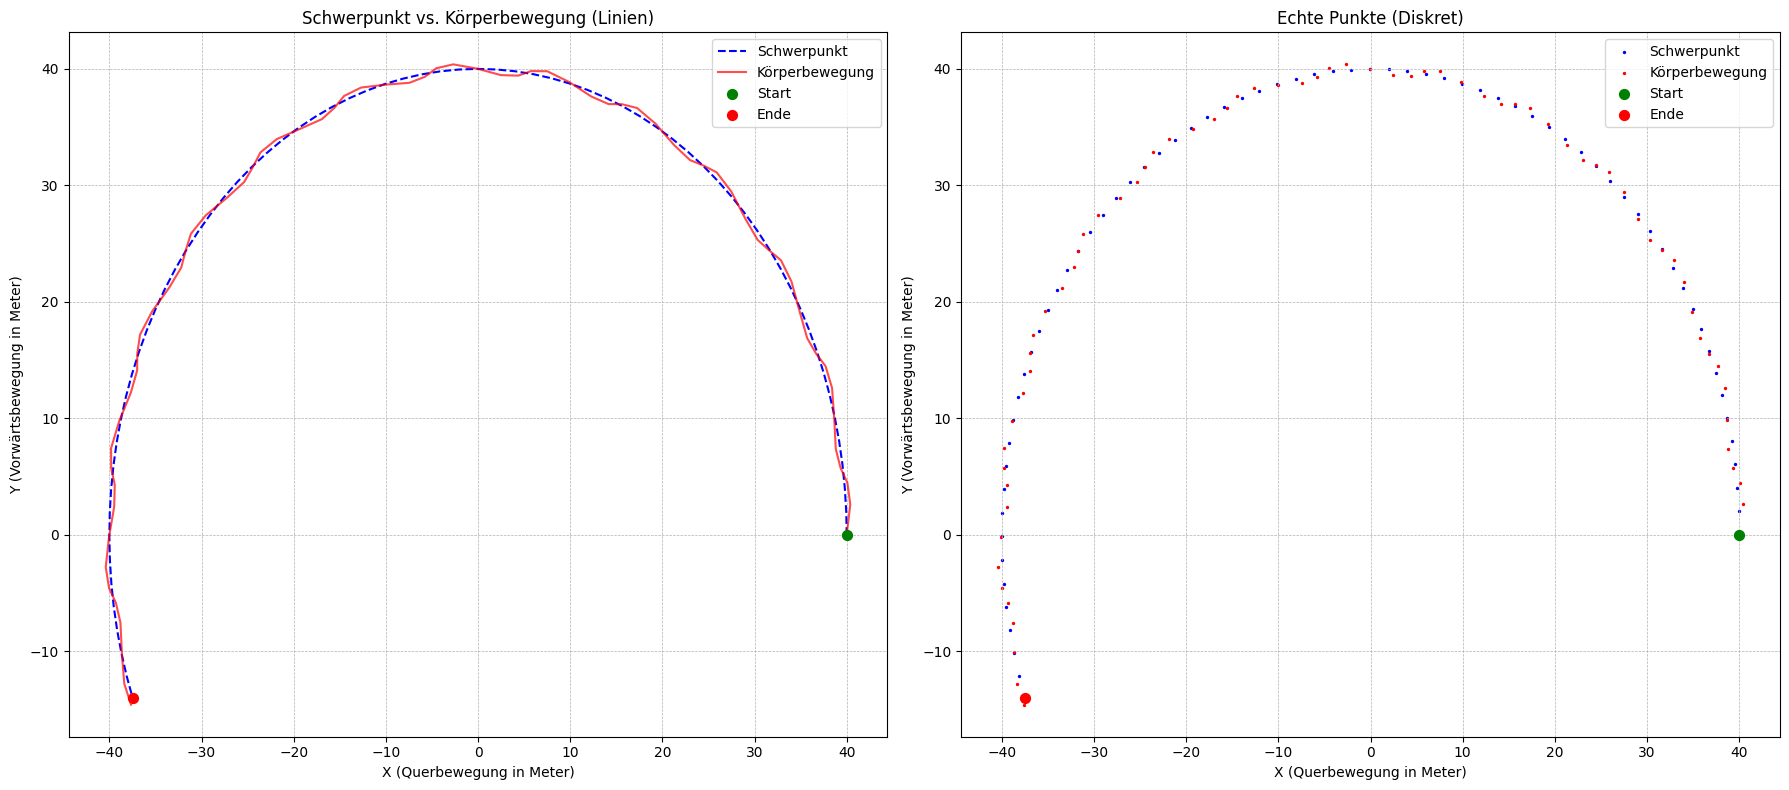

In [122]:
df_lof = generate_testdata_LOF(R=40, V=20, periods=24, A_xLR=0.5, A_yVZ=0.6)

In [180]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def Nur_Savitzky_golay(
    df: pd.DataFrame,
    filter_for: tuple = ("x", "y", "elevation"),
    window_size: int = 11,
    order: int = 3,
    plot: bool = True,
    plot_2d: bool = True,
    plot_3d: bool = True
) -> pd.DataFrame:

    # === Glättung ===
    for col in filter_for:
        if col not in df.columns:
            print(f"Spalte '{col}' nicht gefunden – übersprungen.")
            continue
        try:
            df[f"{col}_sp_SG"] = savgol_filter(df[col].values, window_size, order)
        except Exception as e:
            print(f"Fehler bei '{col}': {e}")

    # === Plotting ===
    # 2D: Pfad im XY-Raum
    if plot_2d and "x_sp_SG" in df.columns and "y_sp_SG" in df.columns:
        plt.figure(figsize=(8, 6))
        plt.plot(df["x"], df["y"], label="XY_echt", alpha=0.5, color="red")
        plt.plot(df["x_sp_SG"], df["y_sp_SG"], label="XY_sp", linewidth=2, color="blue")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("2D-Trajektorie im XY-Raum")
        plt.legend()
        plt.grid(True)
        plt.axis("equal")
        plt.tight_layout()
        plt.show()

    # 3D-Trajektorie
    if plot_3d and all(f"{col}_sp_SG" in df.columns for col in filter_for):
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Original in Rot
        ax.plot(df[filter_for[0]], df[filter_for[1]], df[filter_for[2]],
                label="Original", alpha=0.5, color="red")

        # Geglättet in Blau
        ax.plot(
            df[f"{filter_for[0]}_sp_SG"],
            df[f"{filter_for[1]}_sp_SG"],
            df[f"{filter_for[2]}_sp_SG"],
            label="SG-geglättet", linewidth=2, color="blue"
        )

        ax.set_xlabel(filter_for[0])
        ax.set_ylabel(filter_for[1])
        ax.set_zlabel(filter_for[2])
        ax.set_title("3D-Trajektorie (SG-Glättung)")
        ax.legend()
        plt.tight_layout()
        plt.show()

    return df


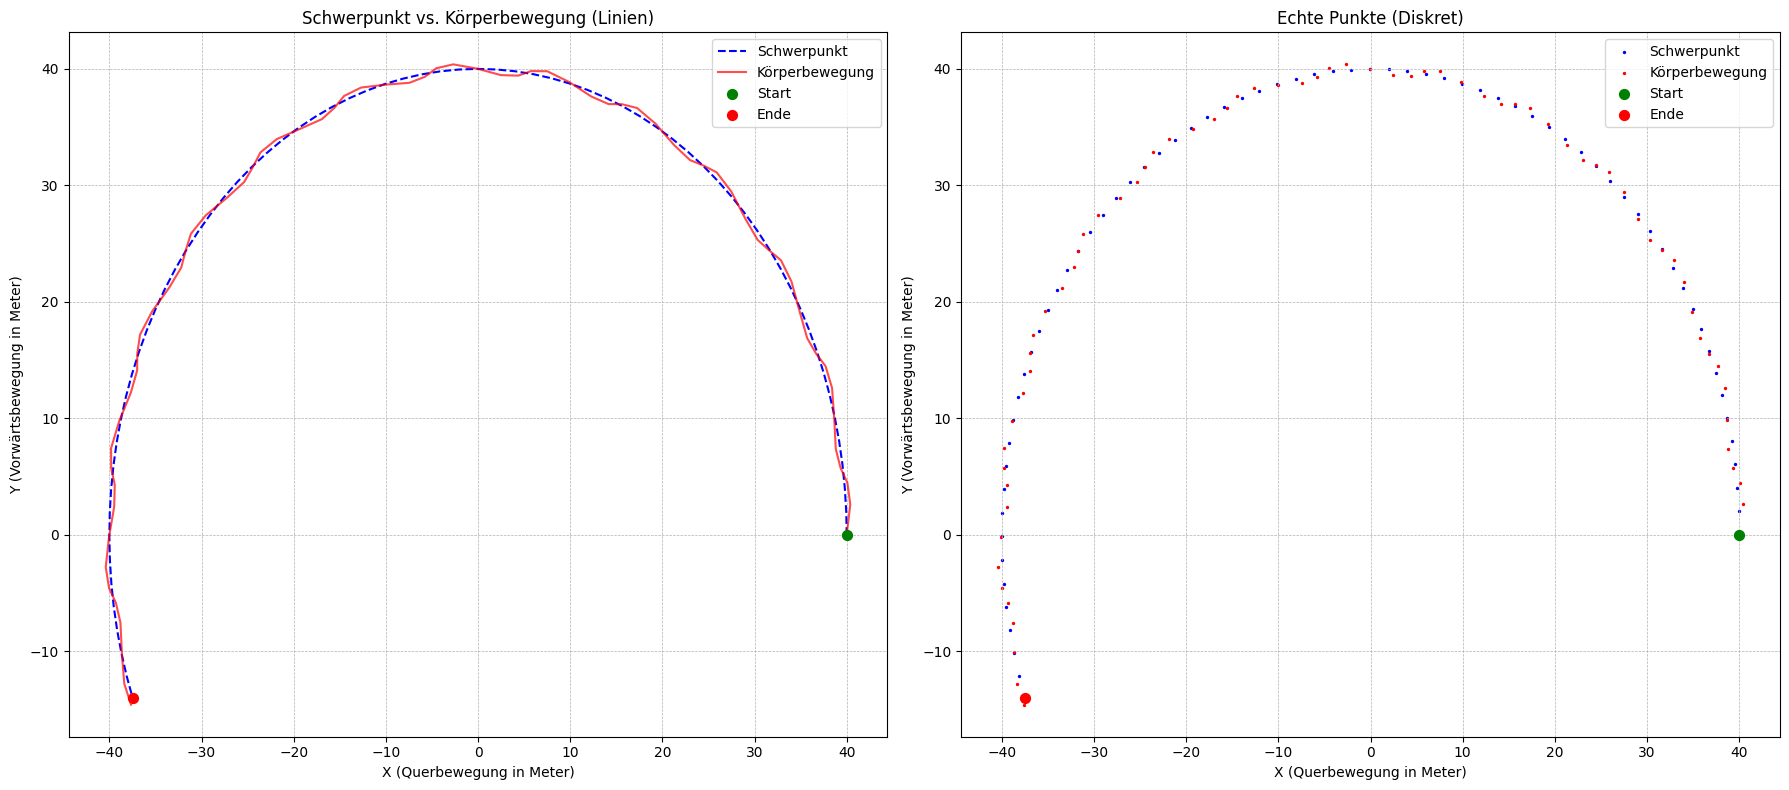

In [178]:
df_lof = generate_testdata_LOF(R=40, V=20, periods=24, A_xLR=0.5, A_yVZ=0.6)

Spalte 'elevation' nicht gefunden – übersprungen.


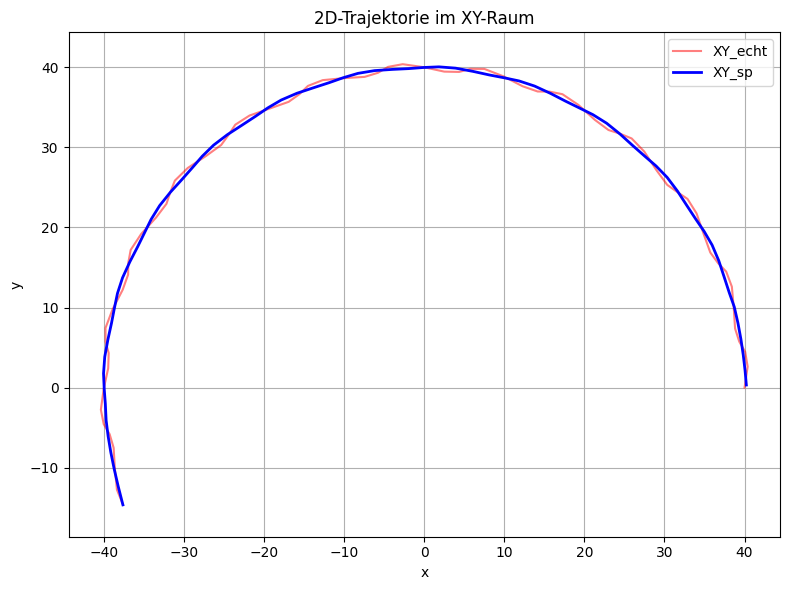

In [201]:
df_lof = Nur_Savitzky_golay(df_lof, filter_for=("x", "y", "elevation"), window_size=11, order=3)

In [203]:
print(sum(df_lof["x_sp_echt"])-sum(df_lof["x_sp_SG"]))

-0.14868962882991354


In [205]:
df_lof["x_sp_echt"]-df_lof["x_sp_SG"]

,0
0,-0.224073
1,-0.114196
2,-0.045188
3,-0.008570
4,0.004401
...,...
65,-0.032784
66,-0.006502
67,0.035607
68,0.096687


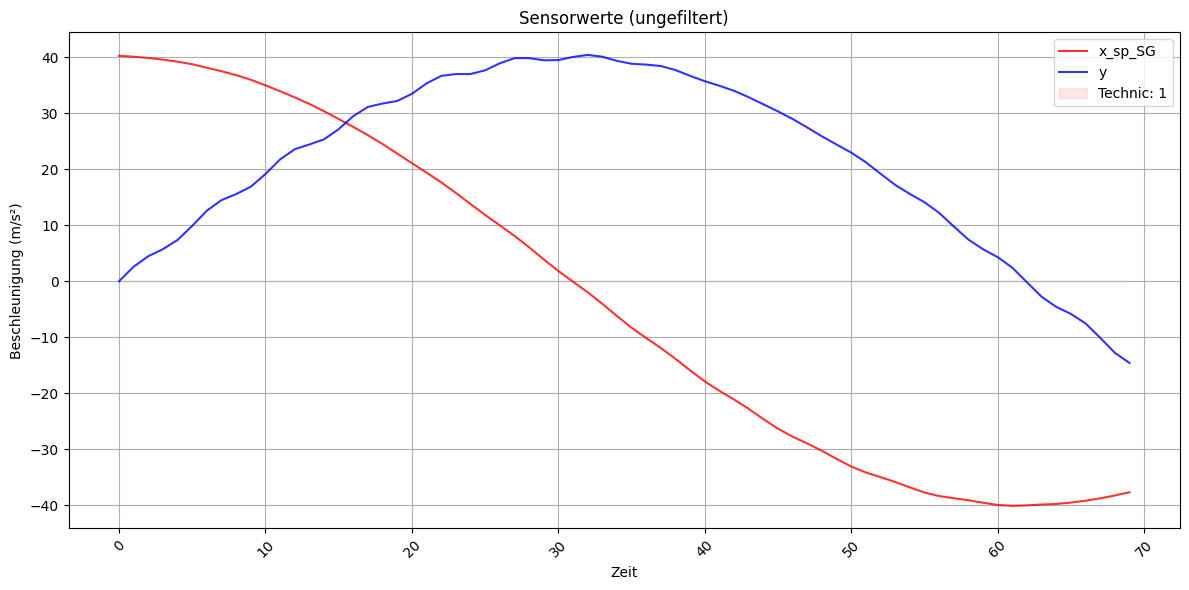

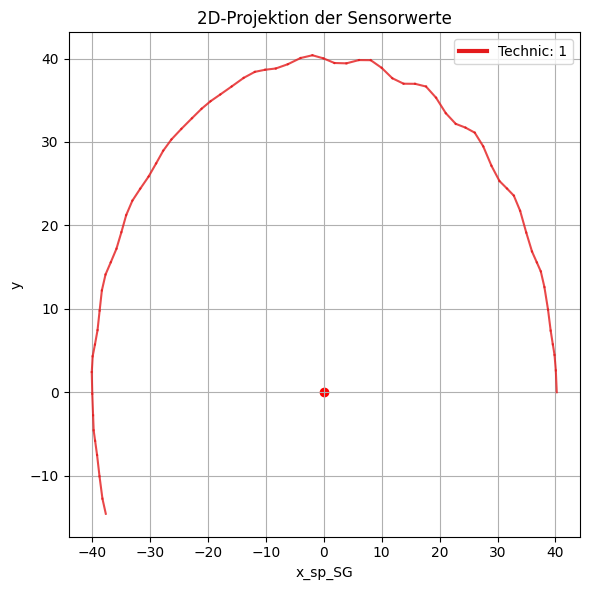

,t,x_sp_echt,y_sp_echt,x,y,phi,x_LR,y_vz,streckenlänge,technic,x_sp_SG,y_sp_SG
0,0.000000,40.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,125.663706,1,40.224073,0.324743
1,0.101449,39.948551,2.028116,40.388506,2.614096,0.050725,0.469100,0.562920,125.663706,1,40.062748,2.143032
2,0.202899,39.794337,4.051014,40.077912,4.471542,0.101449,0.324706,0.389647,125.663706,1,39.839526,4.061887
3,0.304348,39.537755,6.063491,39.340683,5.736630,0.152174,-0.244342,-0.293211,125.663706,1,39.546325,6.046727
4,0.405797,39.179464,8.060371,38.815173,7.380410,0.202899,-0.493837,-0.592604,125.663706,1,39.175064,8.062969
...,...,...,...,...,...,...,...,...,...,...,...,...
65,6.594203,-39.517314,-6.195311,-39.293987,-5.822093,3.297101,-0.278437,-0.334125,125.663706,1,-39.484530,-6.076174
66,6.695652,-39.152366,-8.190984,-38.796091,-7.520625,3.347826,-0.485998,-0.583198,125.663706,1,-39.145864,-8.103625
67,6.797101,-38.686701,-10.165587,-38.648317,-10.083581,3.398551,-0.057965,-0.069558,125.663706,1,-38.722308,-10.192504
68,6.898551,-38.121517,-12.114039,-38.384413,-12.758997,3.449275,0.445875,0.535051,125.663706,1,-38.218204,-12.365633


In [209]:
signal_projection(df_lof, signal_columns=("x_sp_SG", "y", "elevation"), plot=True, plot_2d=True, plot_3d=True)

#  Winkel Phi_smooth bestimmmen, vergleich mit phi_echt

# Beschleunigung aus x, y (2 Fache Ableitung)

# Phi_smooth auf x,y müsste gerade mit Schwingung geben. (Kontrolle mit phi_echt)

# Wiederholung mit Nadine 2 (SG 11/3)